In [2]:
!pip install opencv-python numpy Pillow ipython

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Core libraries for computer vision
import cv2  # OpenCV - the main computer vision library
import numpy as np  # Numerical operations on arrays/images

# Libraries for display in Jupyter Notebook
from PIL import Image, ImageDraw, ImageFont  # Python Imaging Library
from IPython.display import display, clear_output
import IPython.display

print("All libraries imported successfully!")
print(f"OpenCV version: {cv2.__version__}")

All libraries imported successfully!
OpenCV version: 4.12.0


In [4]:
def display_image(frame, frame_size=(500, 300), title="Image"):
    
    # Check if image is normalized (float between 0-1)
    if frame.dtype != np.uint8:
        frame = (frame * 255).astype(np.uint8)
    
    # Handle grayscale images
    if len(frame.shape) == 2:
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    
    # Convert BGR (OpenCV format) to RGB (PIL format)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Resize the frame for display
    frame = cv2.resize(frame, frame_size)
    
    # Convert to PIL Image
    img = Image.fromarray(frame)

    display(img)
    
    return

In [5]:
def capture_frame(video_path, time_sec=1.0):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error: Could not open video file")
        return None
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps if fps > 0 else 0
    
    print(f"Video Info:")
    print(f"   FPS: {fps}")
    print(f"   Total frames: {total_frames}")
    print(f"   Duration: {duration:.2f} seconds")
    
    # Set frame position
    frame_index = int(time_sec * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"Failed to capture frame at {time_sec} seconds")
        return None
    
    print(f"Frame captured at {time_sec} seconds")
    return frame

def enhance_contrast(img):
    """Enhance contrast using histogram equalization."""
    if len(img.shape) == 3:
        # For color images, equalize each channel
        r, g, b = cv2.split(img)
        r_eq = cv2.equalizeHist(r)
        g_eq = cv2.equalizeHist(g)
        b_eq = cv2.equalizeHist(b)
        return cv2.merge((r_eq, g_eq, b_eq))
    else:
        return cv2.equalizeHist(img)
    
def apply_clahe(img, clip_limit=2.0, tile_size=(25, 25)):
    """Apply CLAHE for adaptive contrast enhancement."""
    # Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
    l_enhanced = clahe.apply(l)
    
    # Merge back
    lab_enhanced = cv2.merge((l_enhanced, a, b))
    return cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)



PREPROCESSING

In [6]:
def preprocess_image(frame):
    
    if frame is None:
        return None
    
    # Convert to HSV
    lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)

    lab = cv2.medianBlur(lab, 3)    #small  odd kernel

    return lab


THRESHOLDING

In [7]:
def thresholding(img1):
    if img1 is not None:
        
        L, A, B = cv2.split(img1)
        
        A = cv2.medianBlur(A, 5)
        
        mask_A = cv2.inRange(A, 130, 180)  #135 but 130 (optmal)-133(maybe) for vid 115 #180
        mask_B = cv2.inRange(B, 145, 190)  #145 for 117     #was 180 but for vid 9113- 200
        mask_L = cv2.inRange(L, 200, 255)  #200
        
        combined = cv2.bitwise_and(mask_A, mask_B)
        combinedv2 = cv2.bitwise_and(combined, mask_L)

        display_image(combinedv2, title="Binary Image")
        return combinedv2

REFINEMENT

In [8]:
def refinement(gray):
    if gray is None:
        return None

    _, binary = cv2.threshold( gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    binary = cv2.morphologyEx(binary, cv2.MORPH_ERODE, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    binary = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6,6))
    binary = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12,12))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    

    display_image(binary, title="")
    
    return binary       
        
       


Video opened successfully.


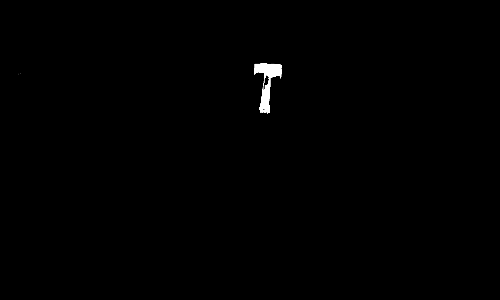

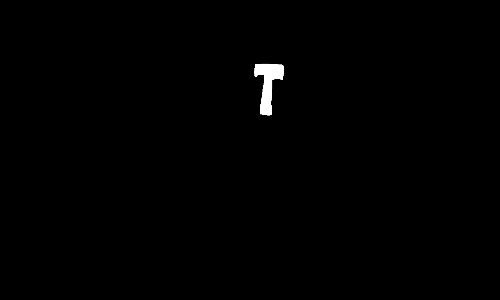

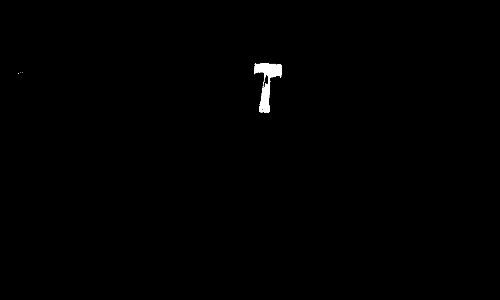

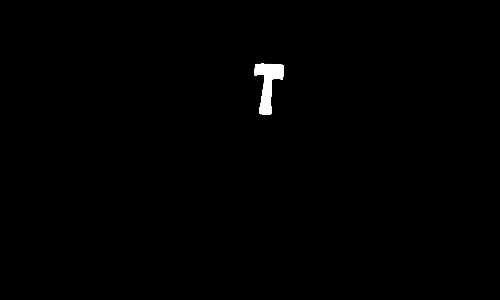

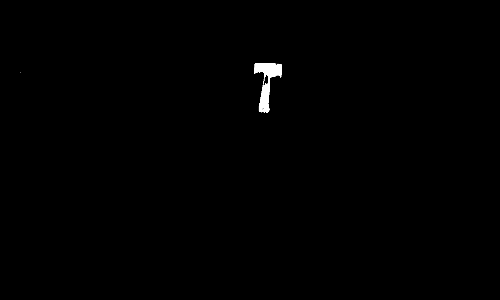

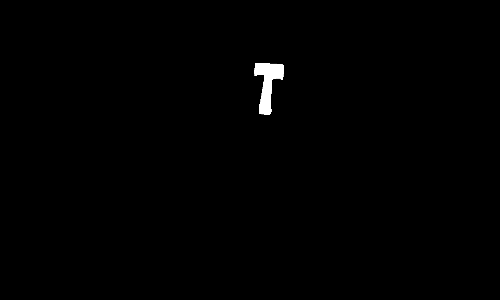

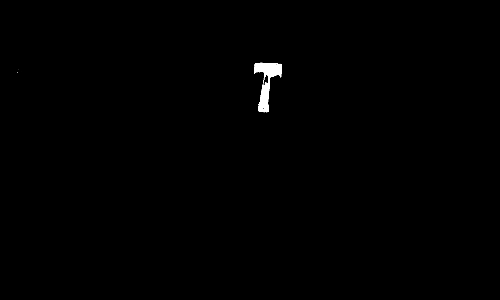

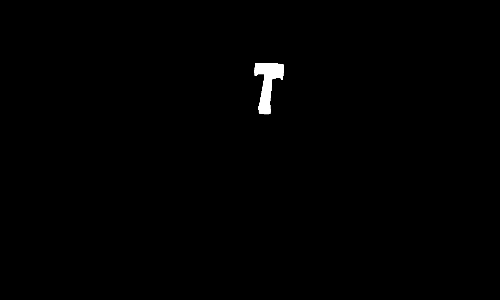

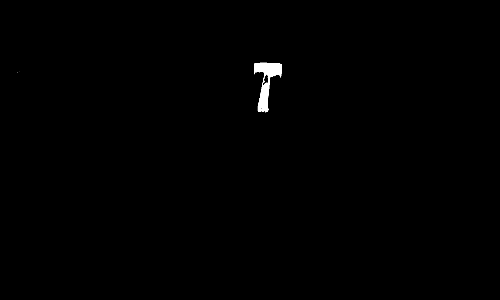

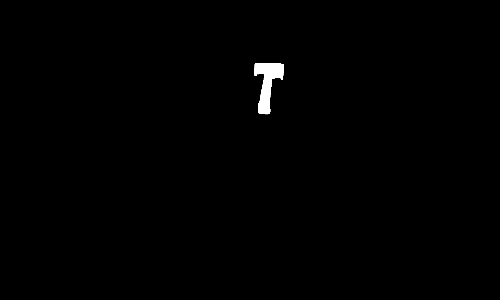

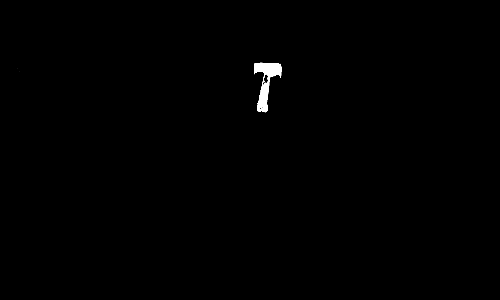

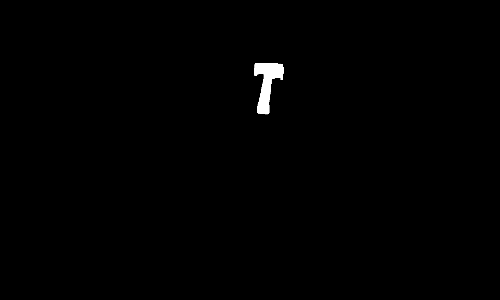

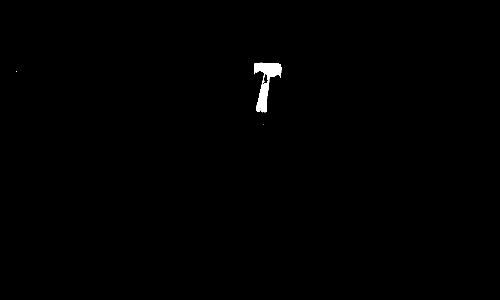

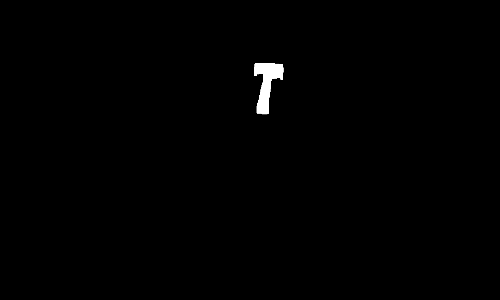

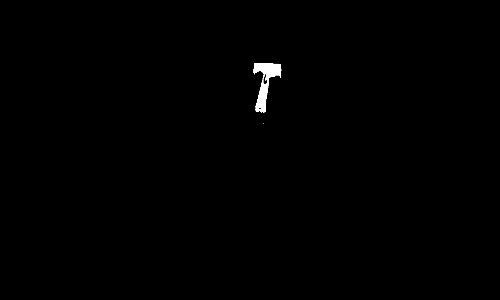

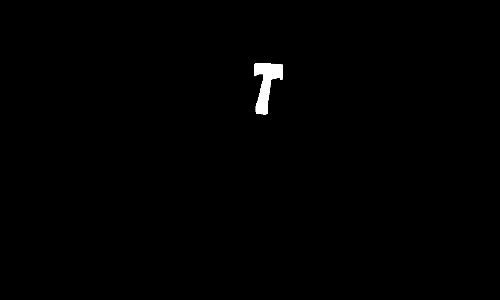

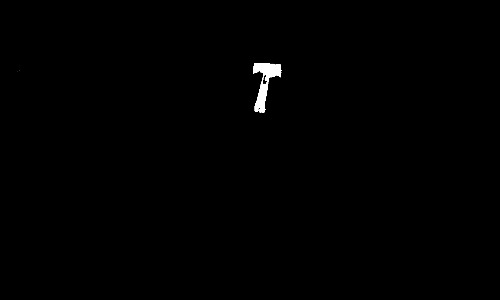

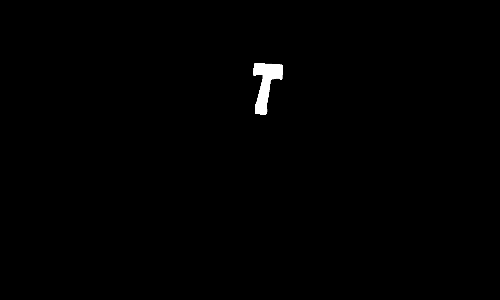

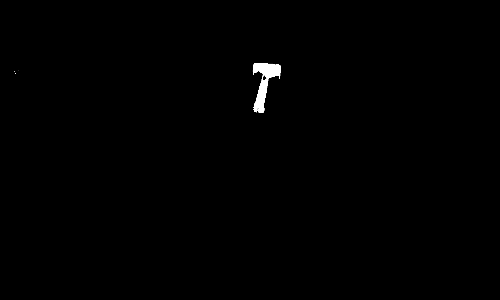

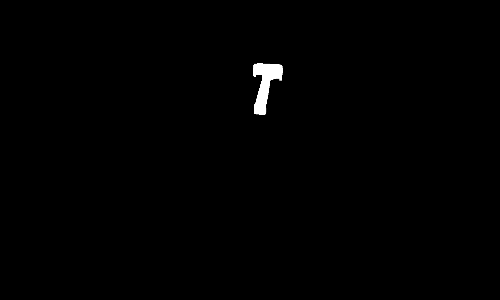

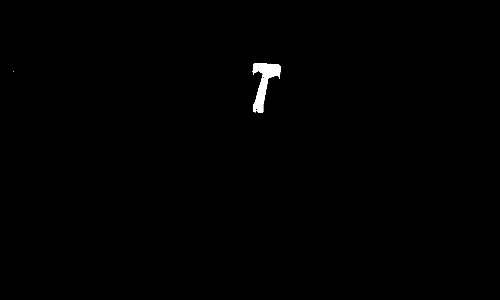

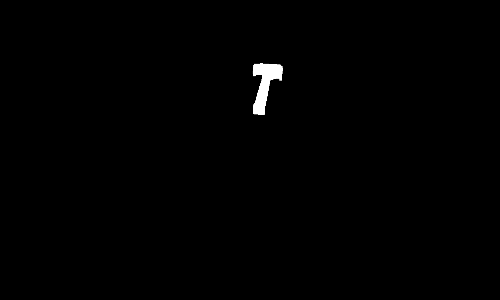

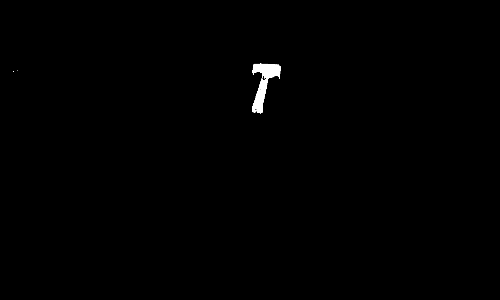

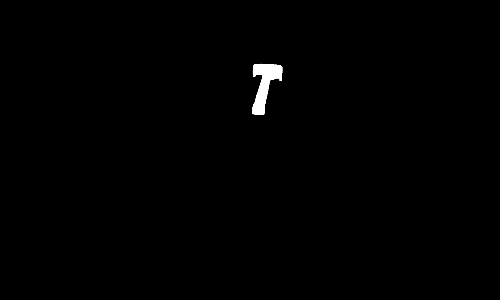

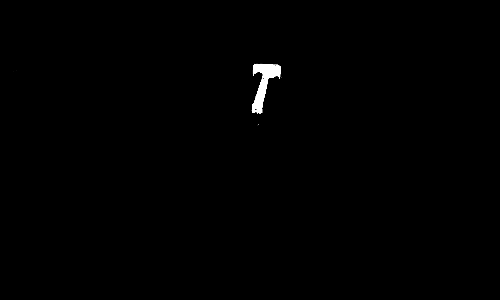

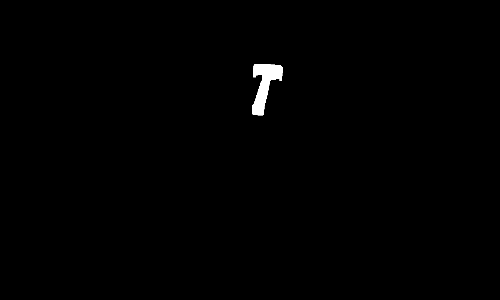

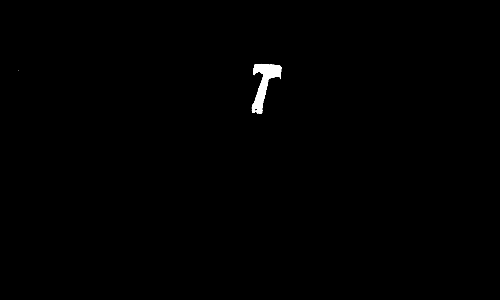

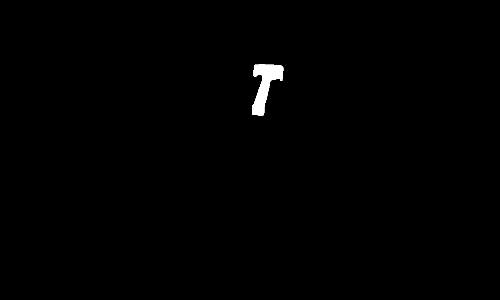

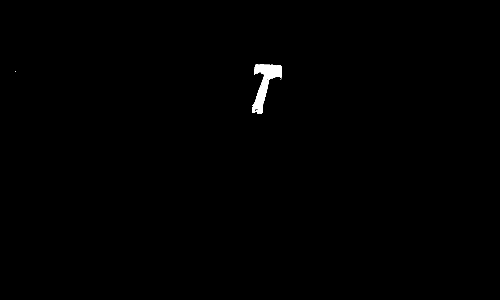

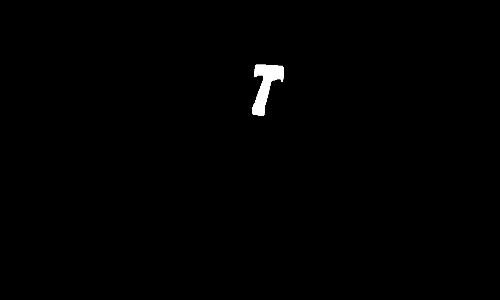

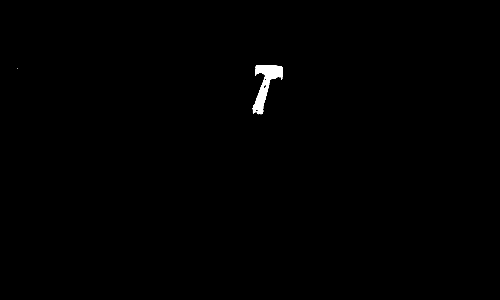

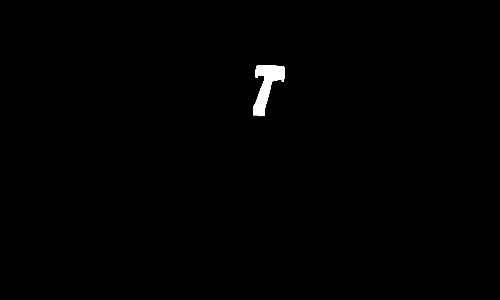

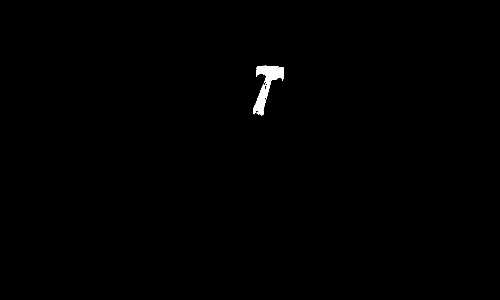

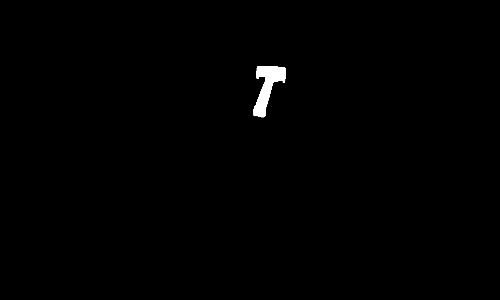

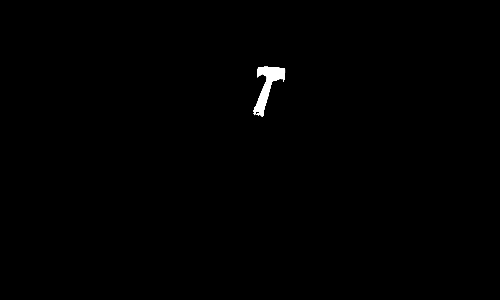

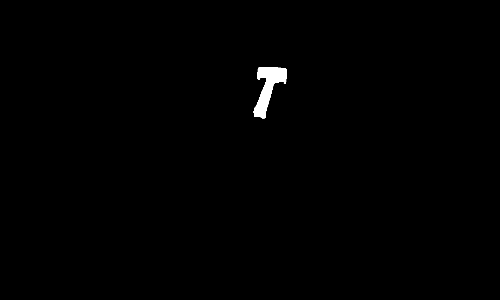

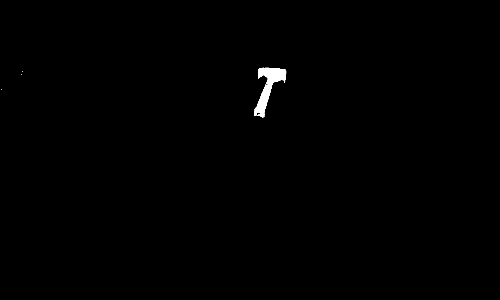

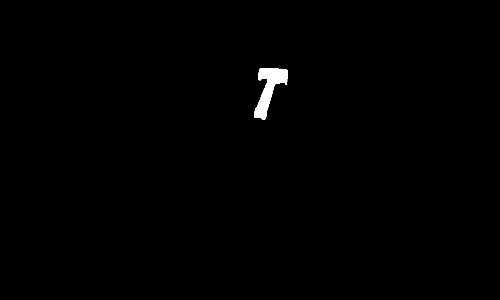

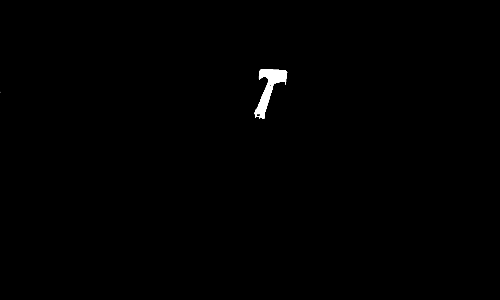

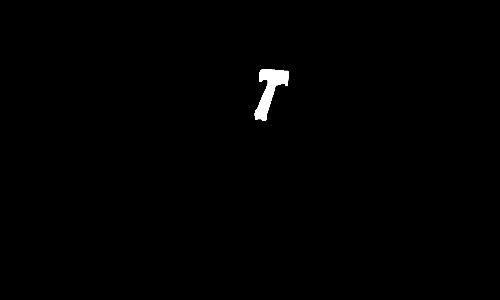

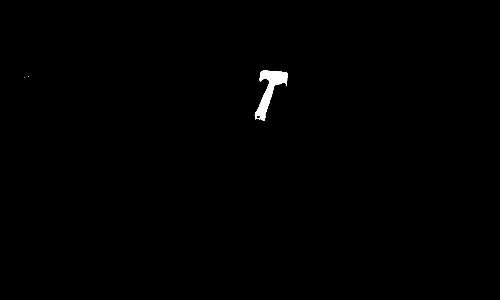

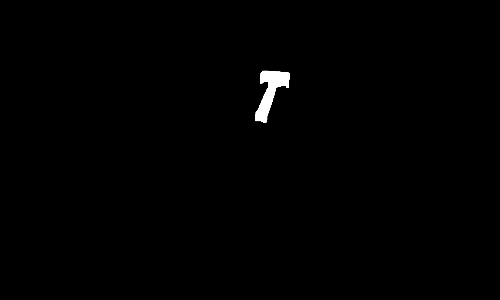

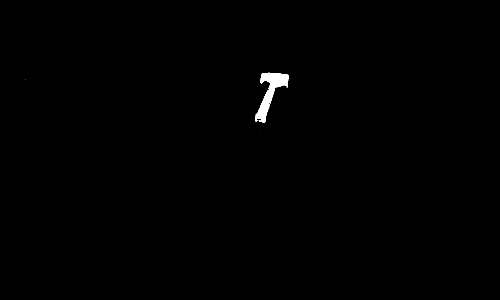

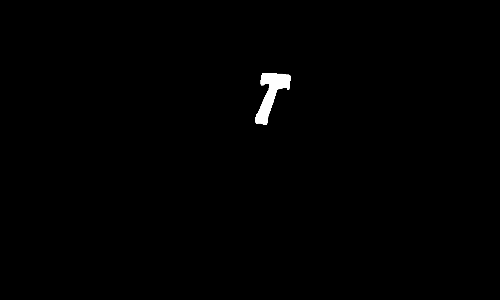

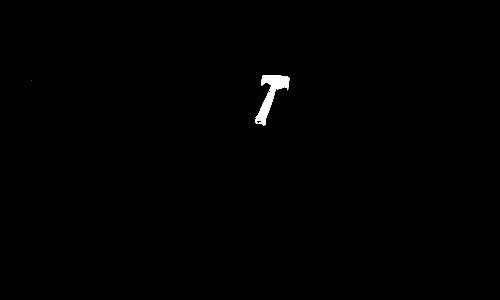

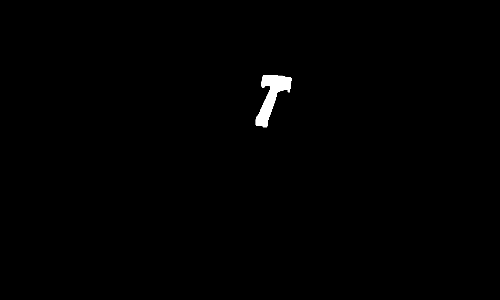

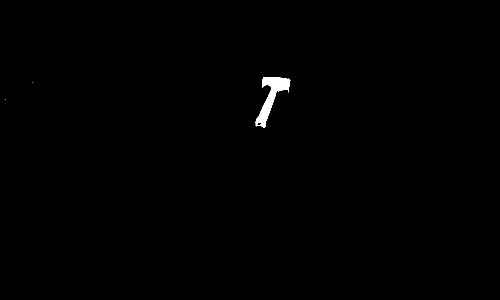

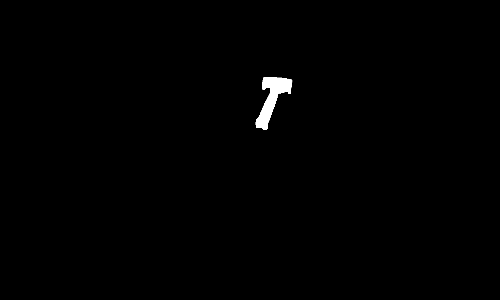

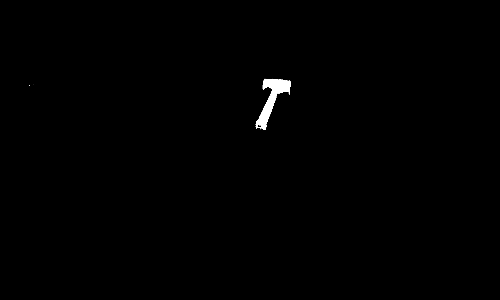

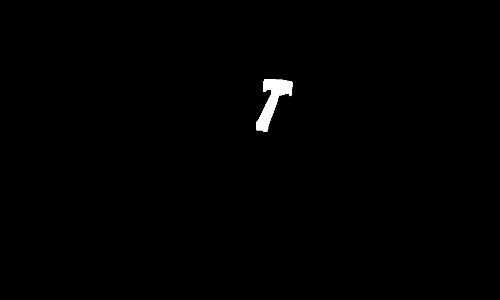

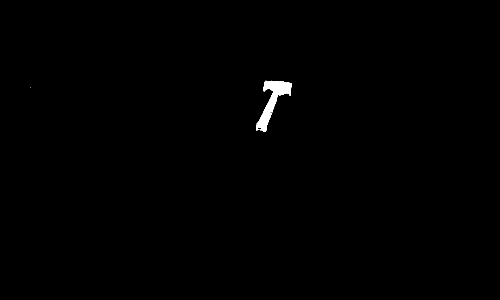

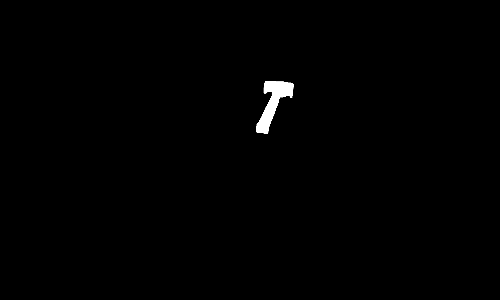

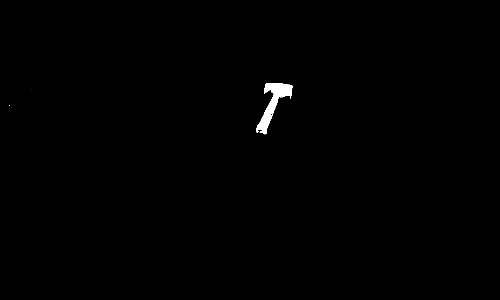

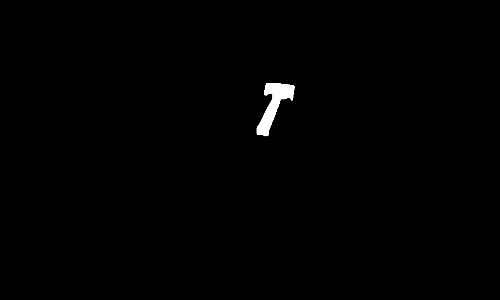

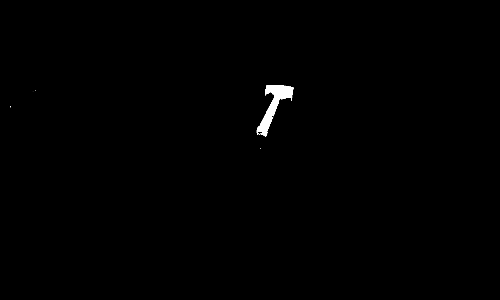

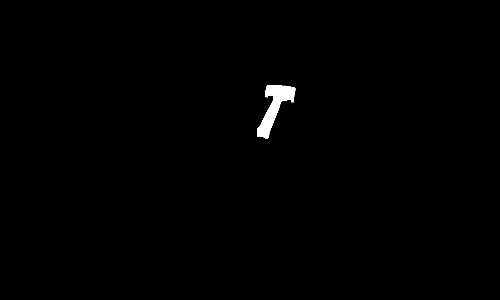

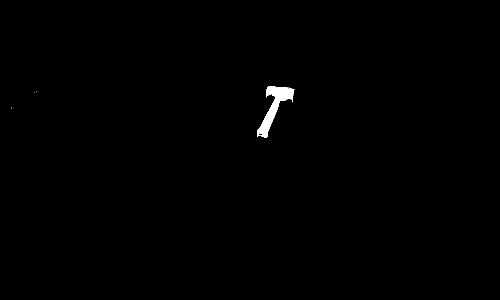

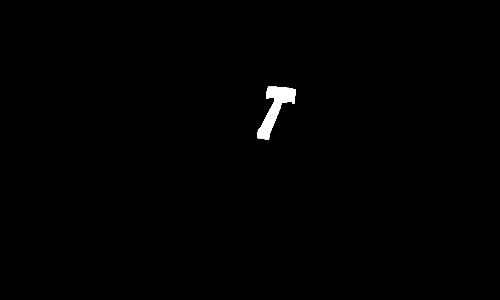

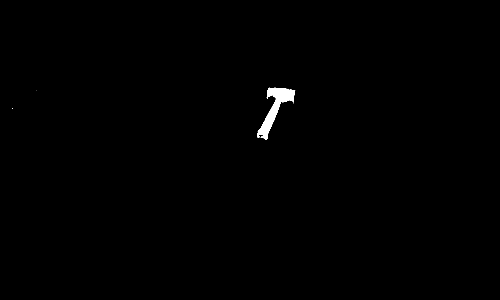

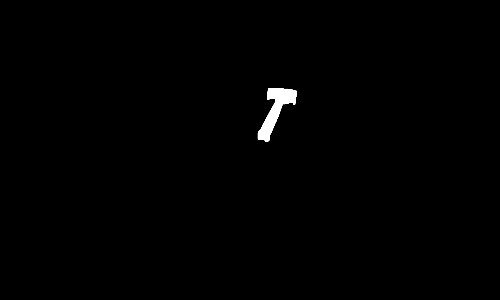

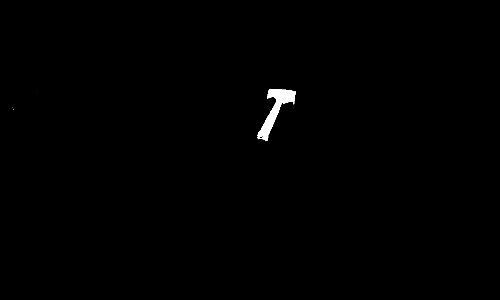

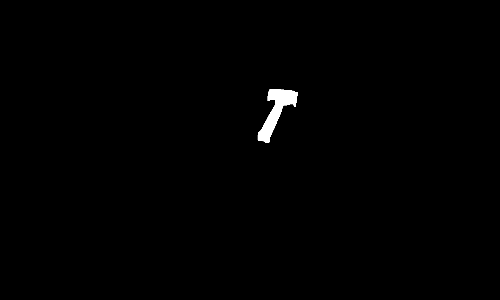

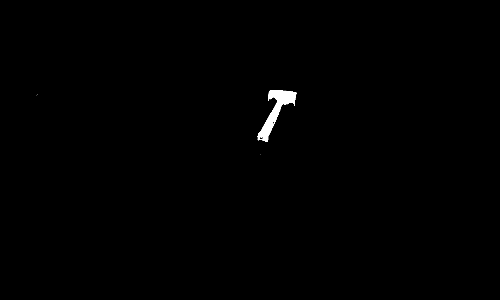

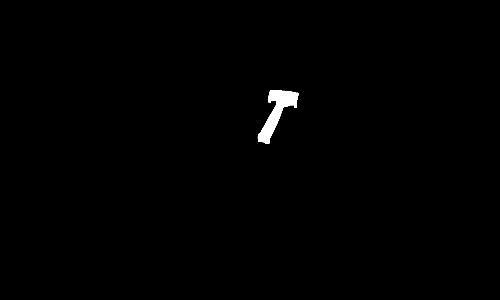

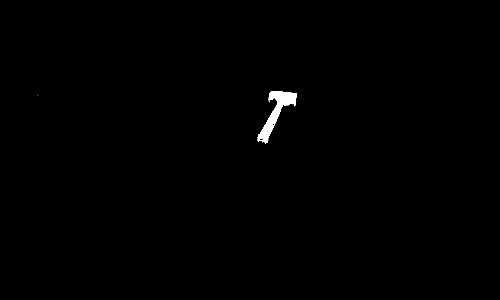

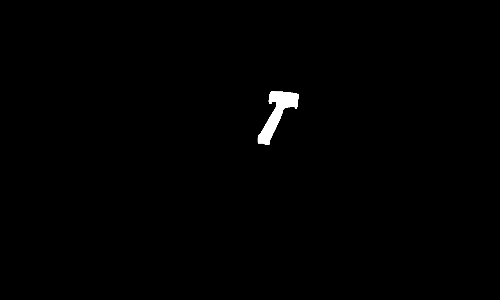

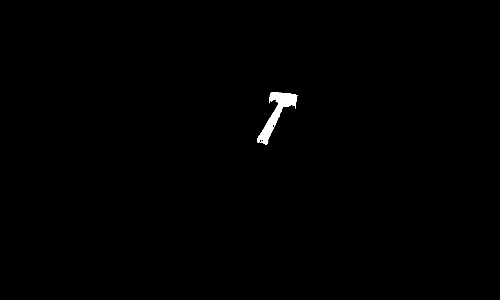

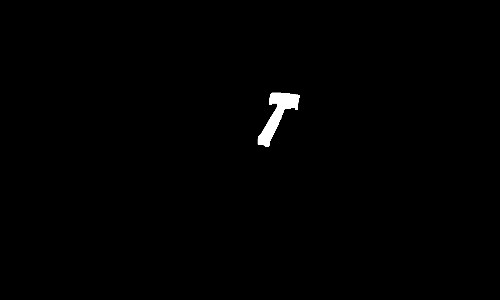

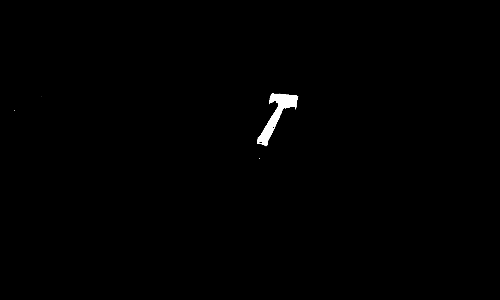

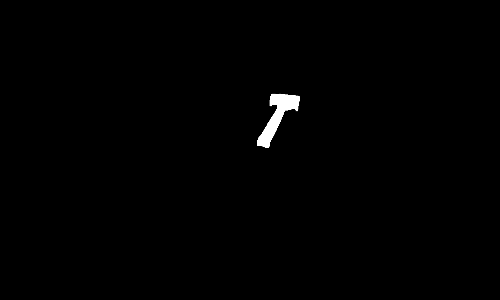

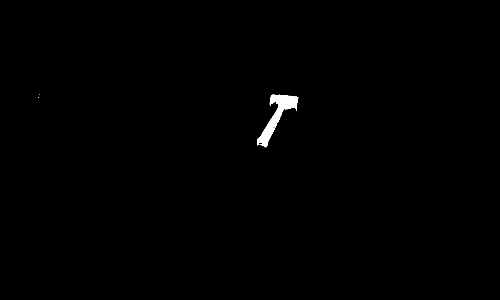

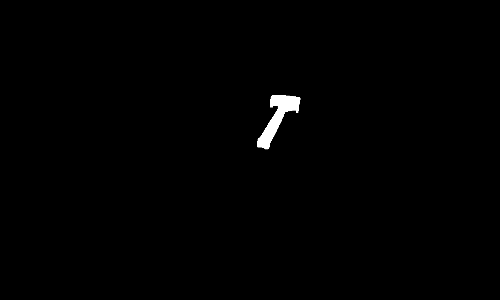

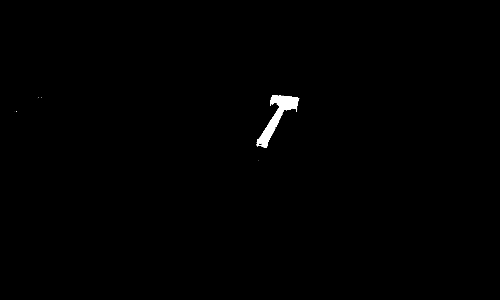

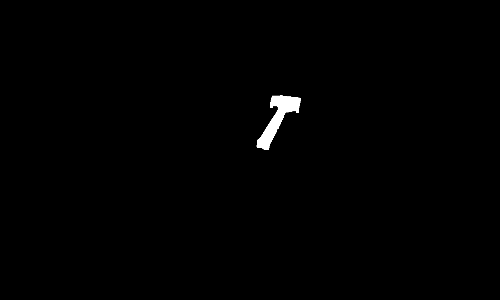

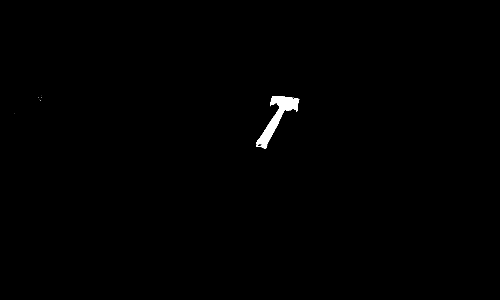

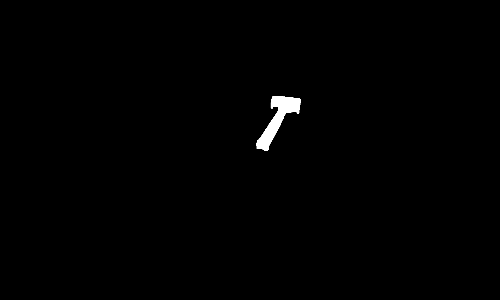

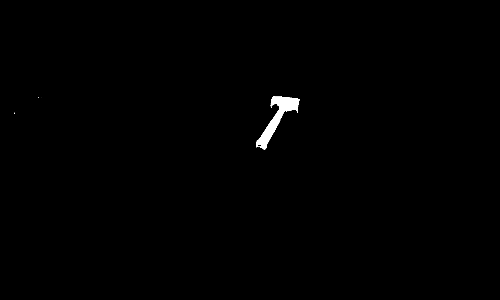

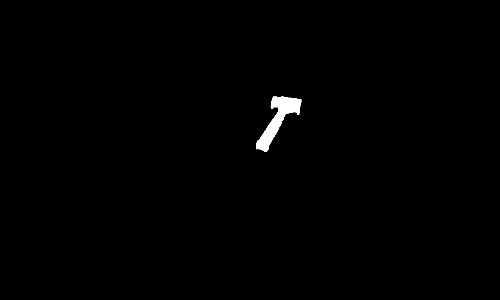

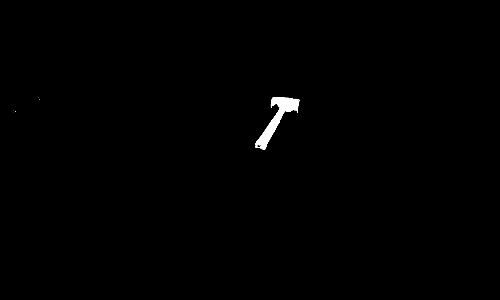

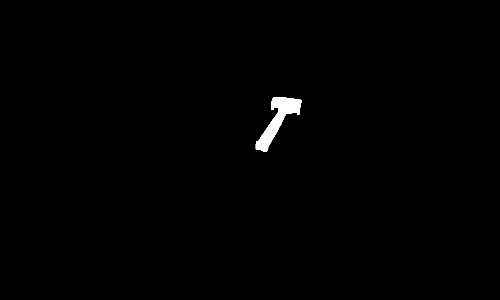

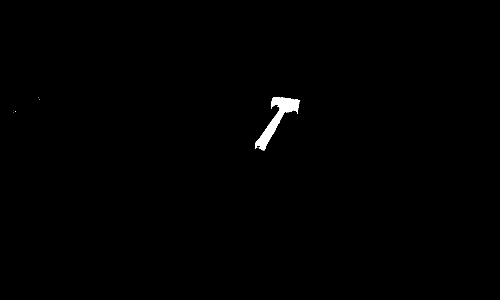

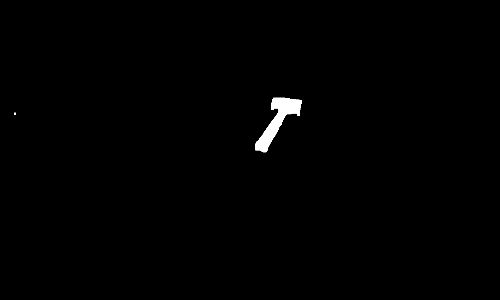

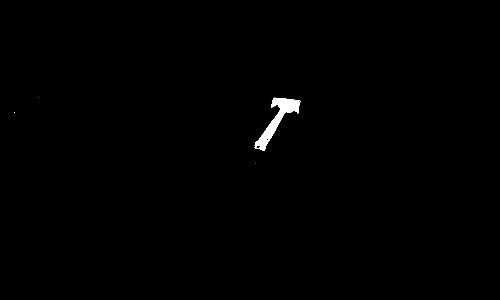

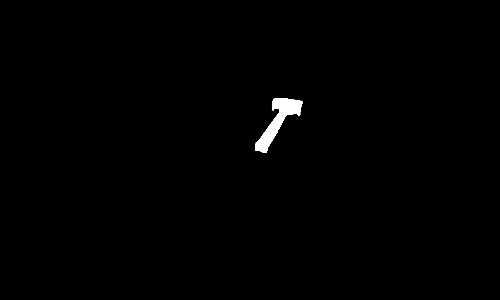

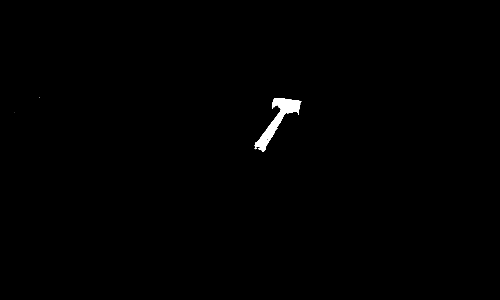

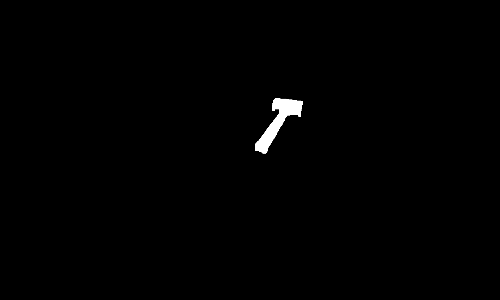

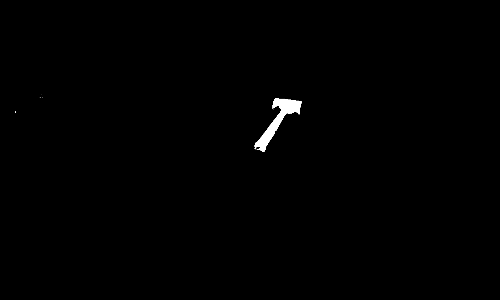

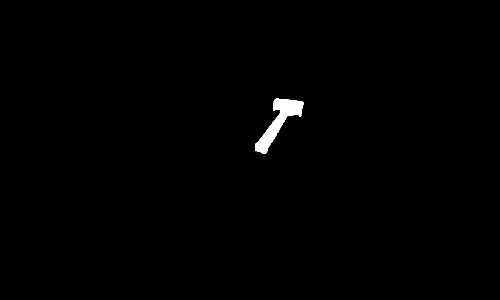

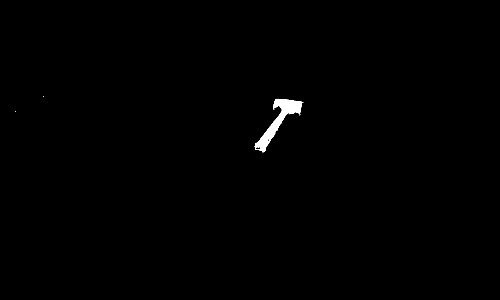

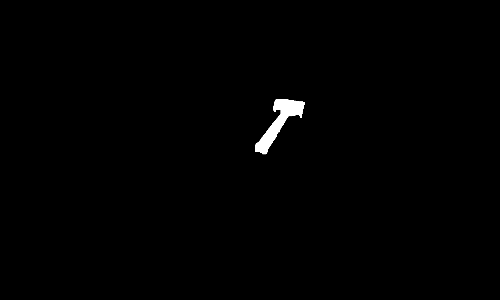

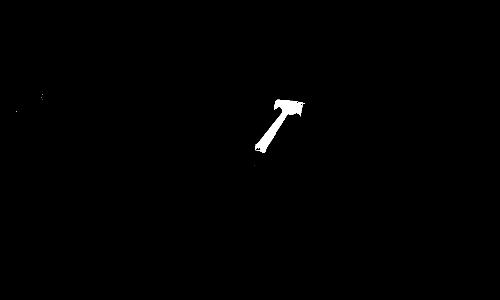

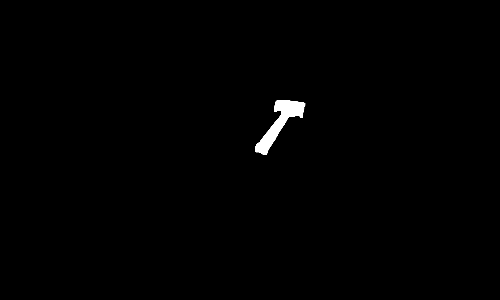

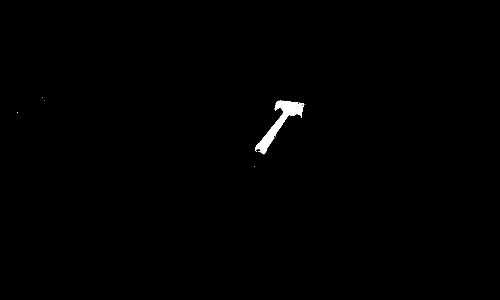

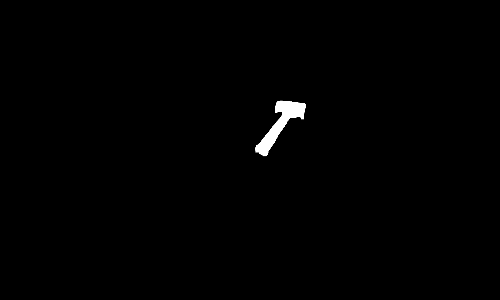

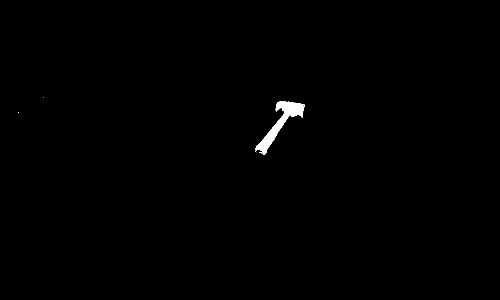

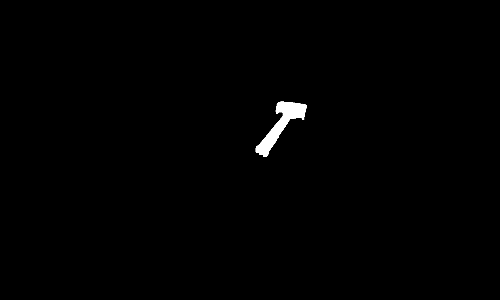

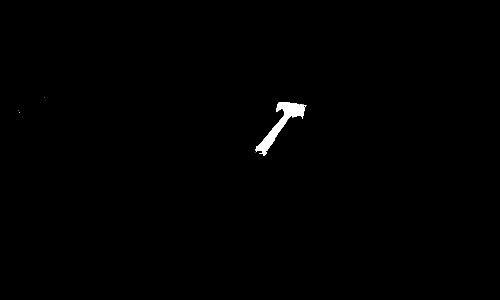

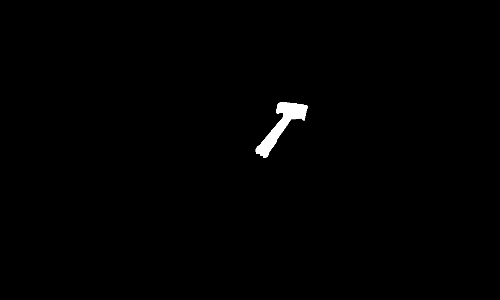

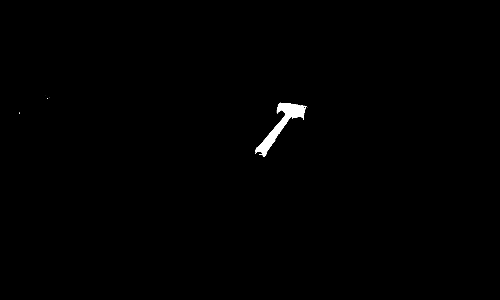

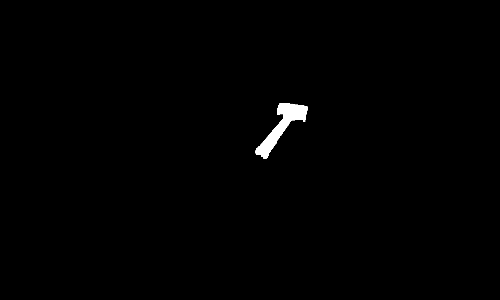

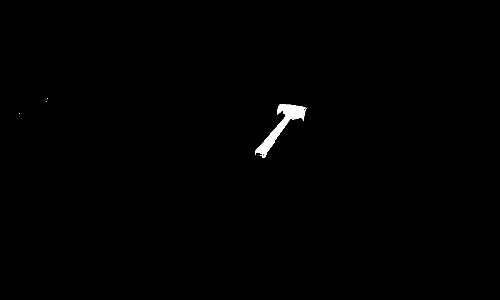

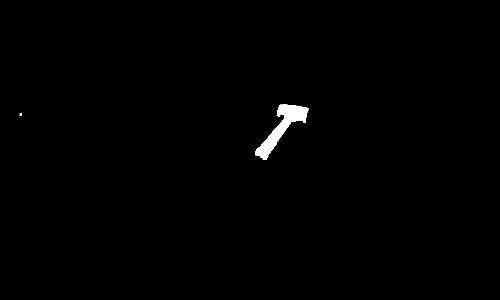

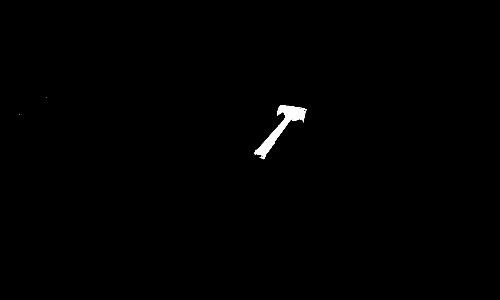

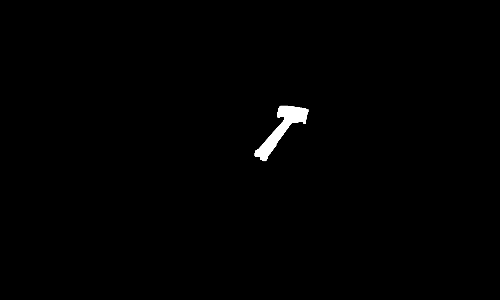

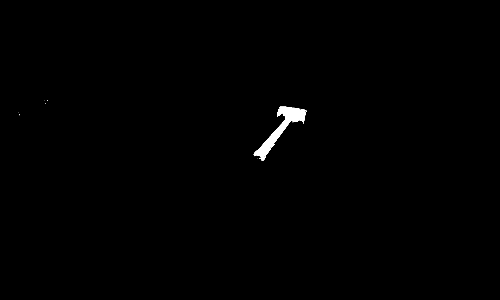

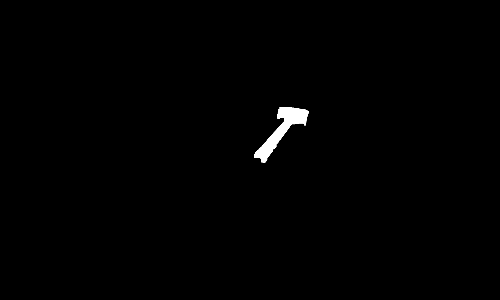

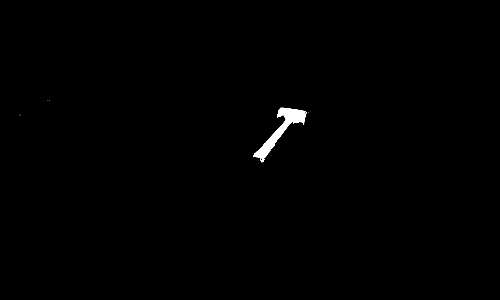

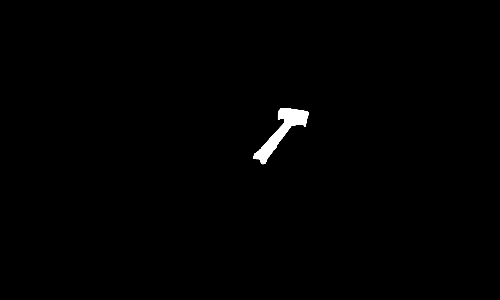

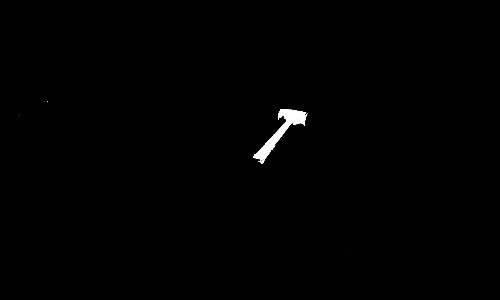

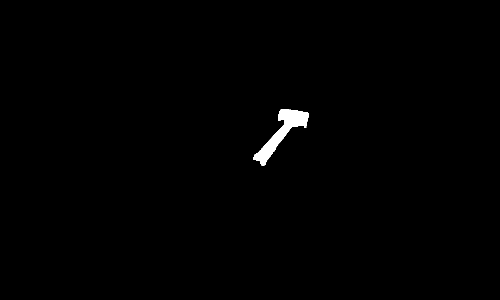

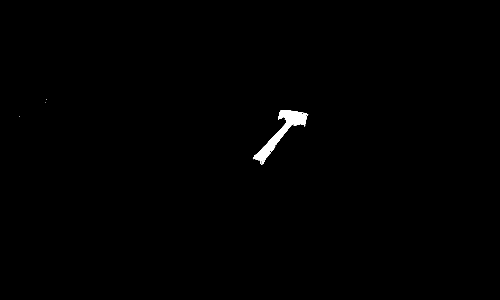

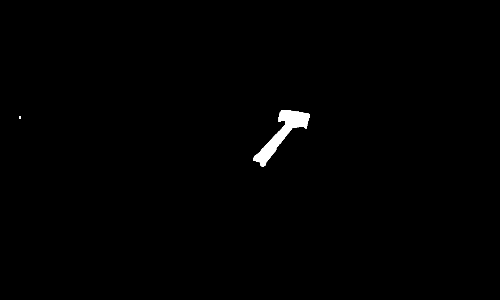

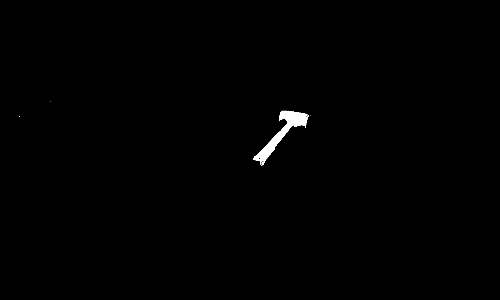

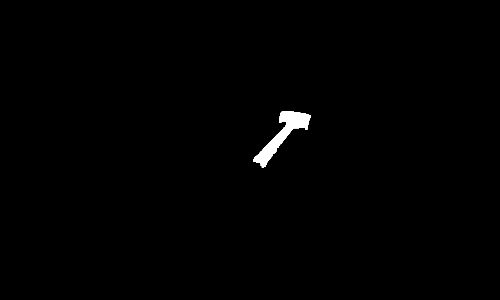

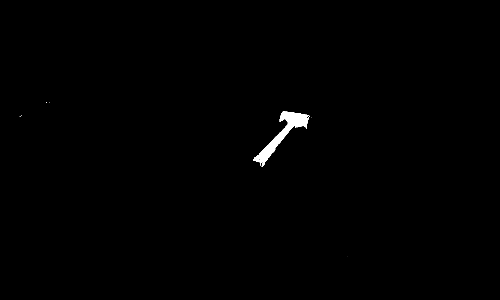

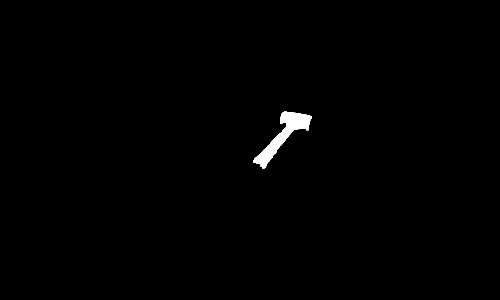

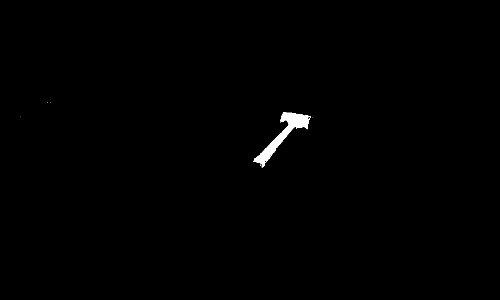

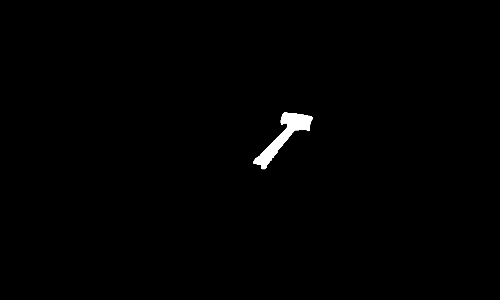

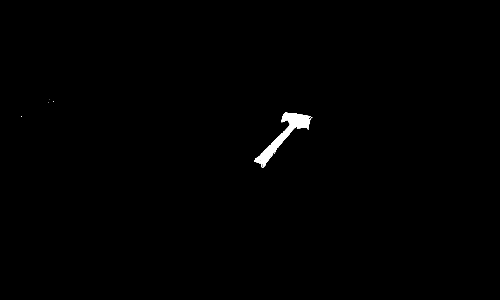

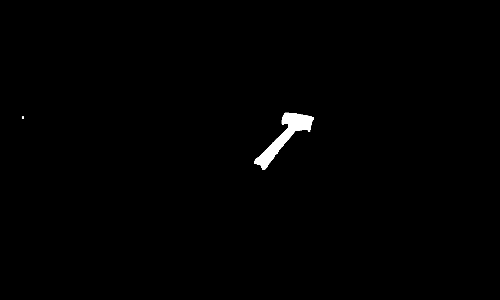

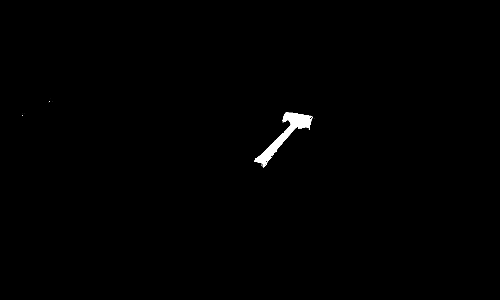

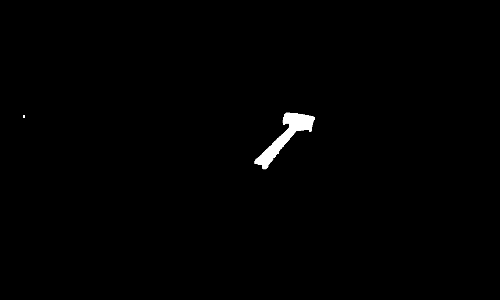

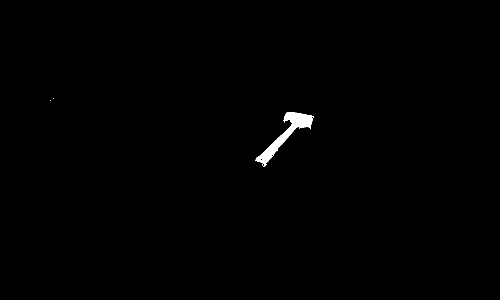

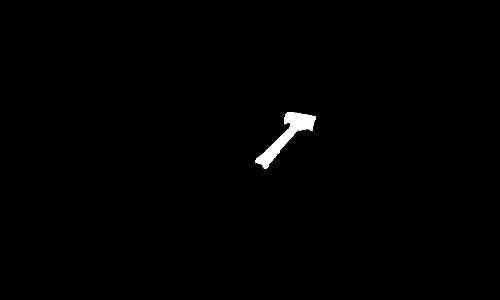

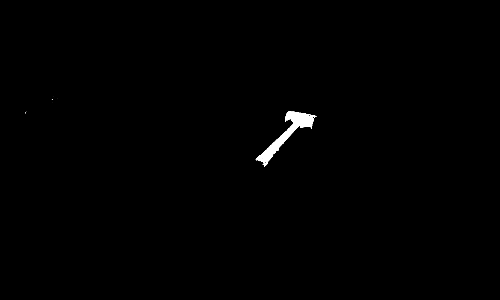

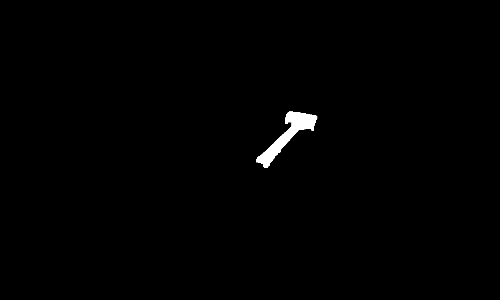

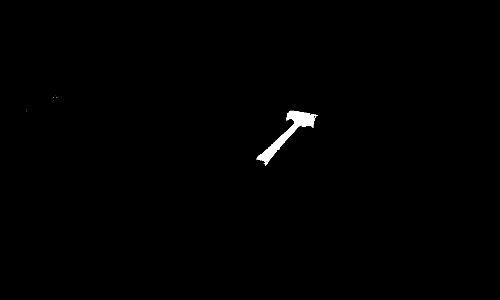

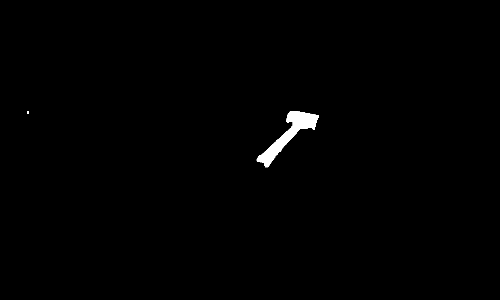

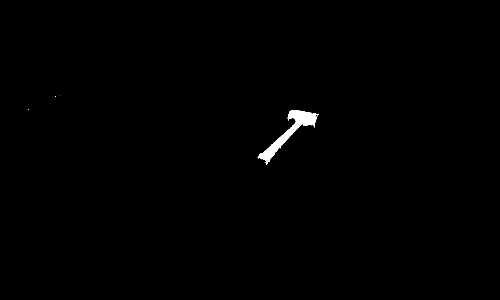

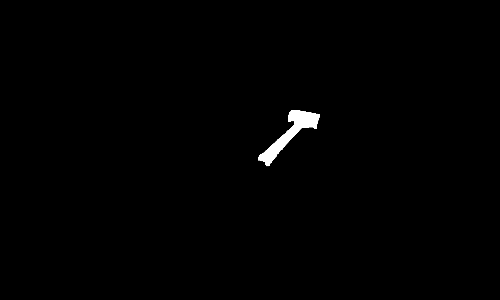

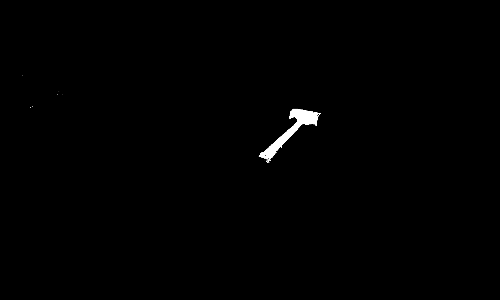

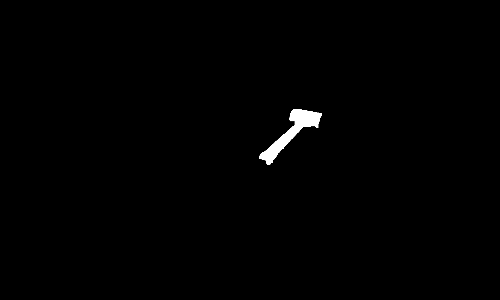

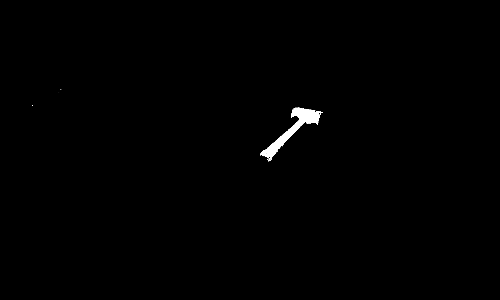

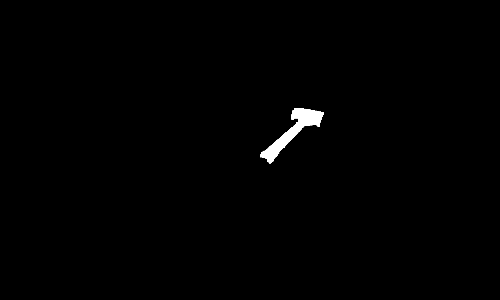

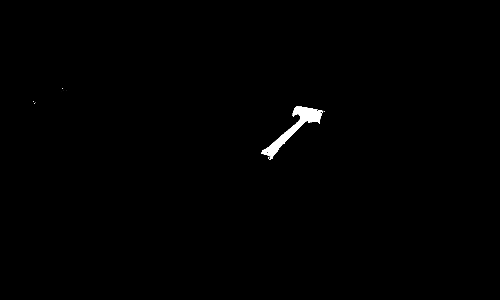

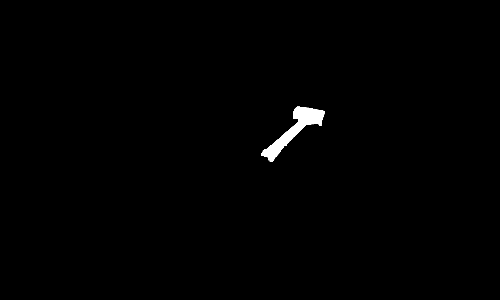

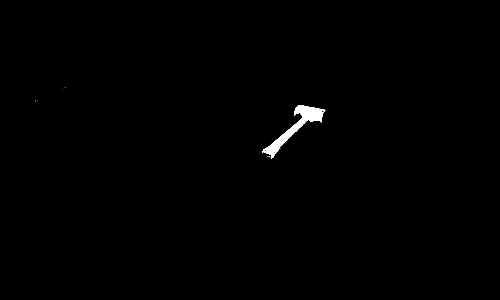

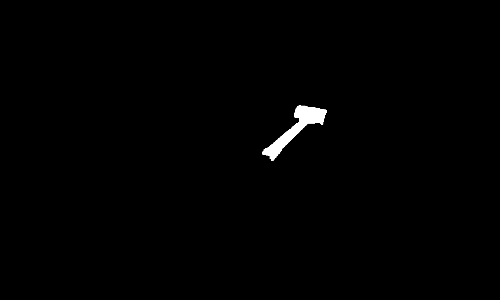

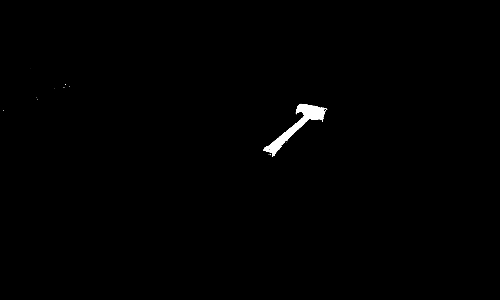

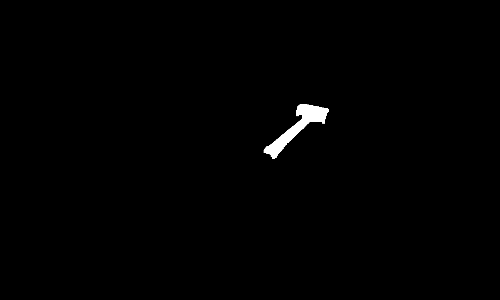

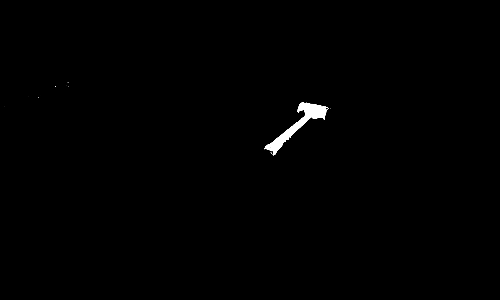

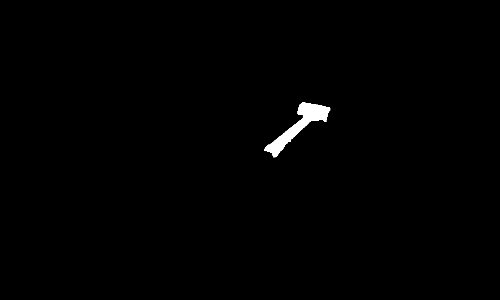

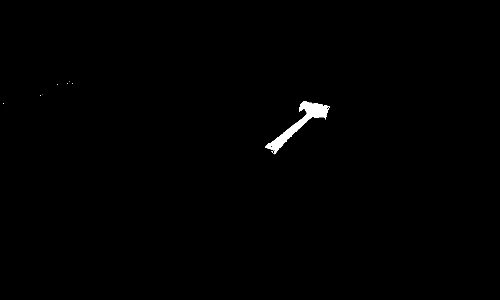

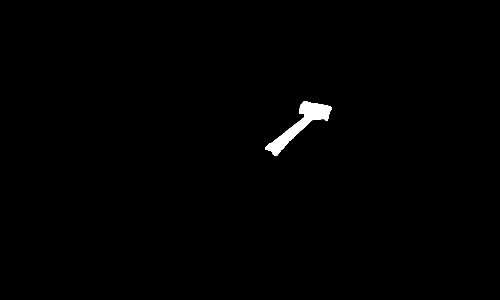

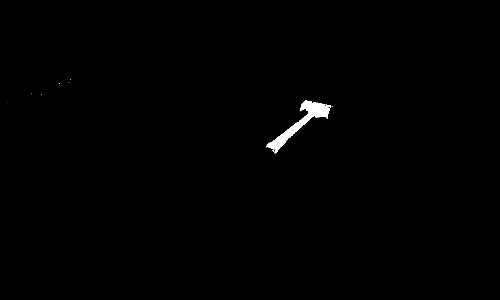

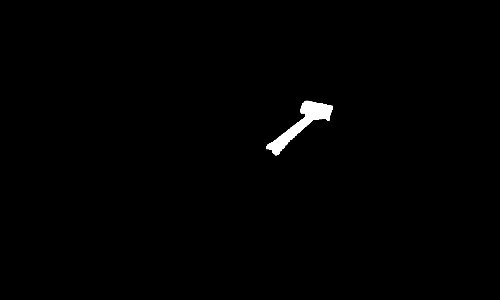

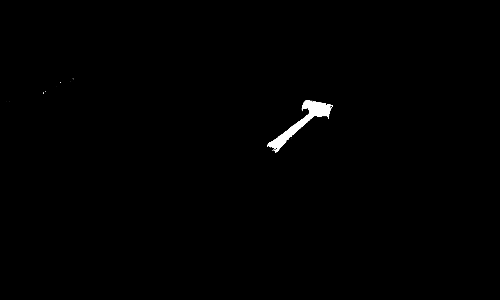

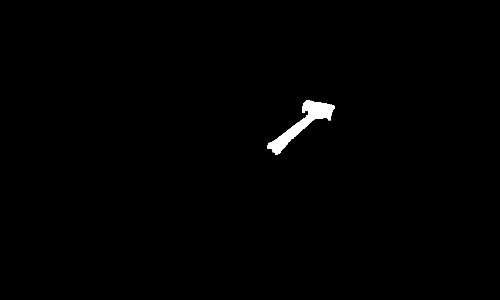

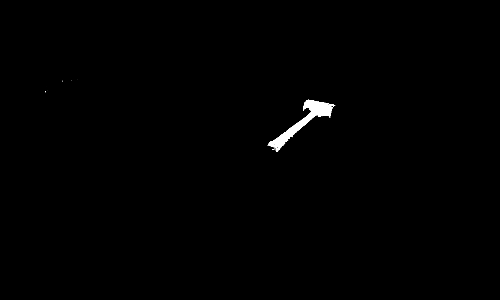

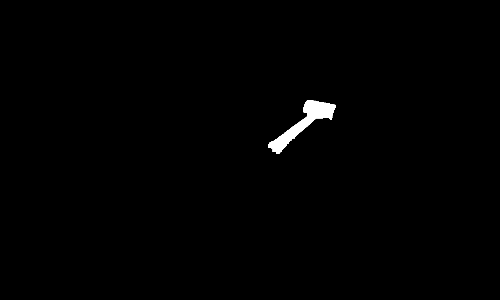

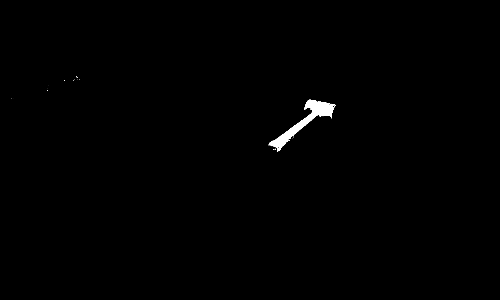

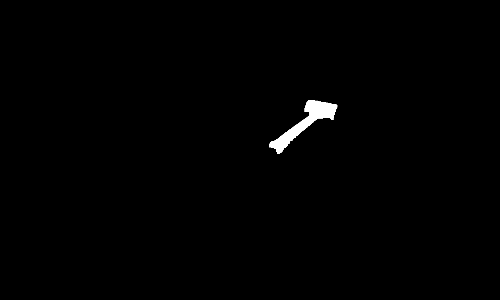

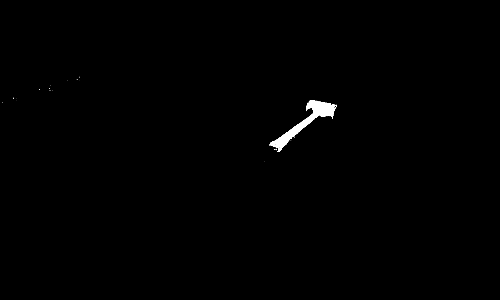

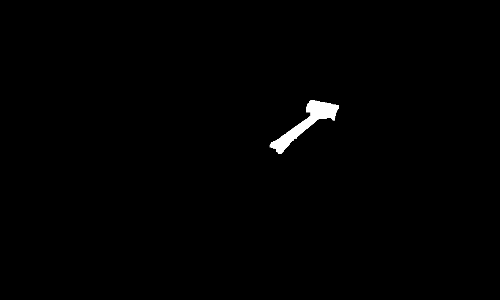

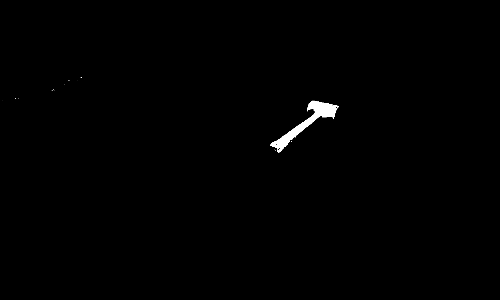

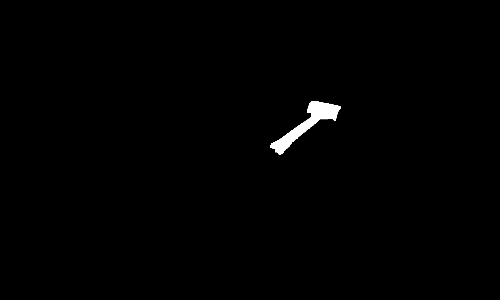

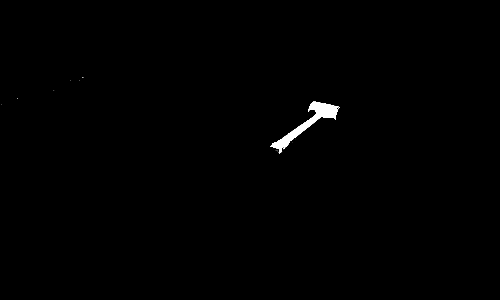

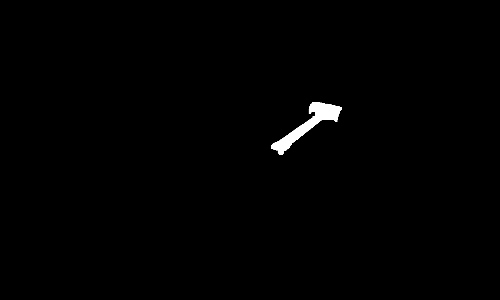

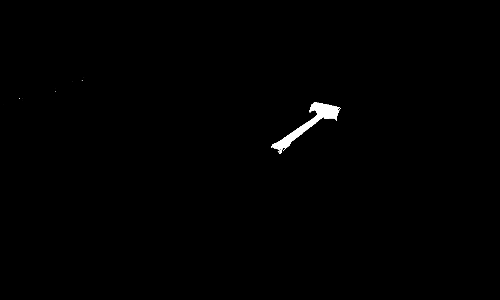

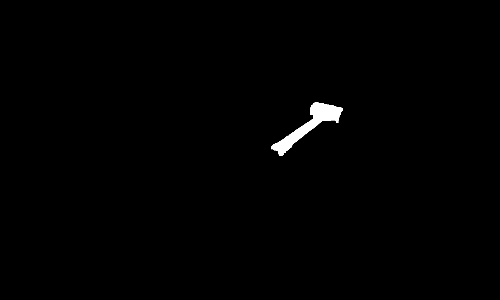

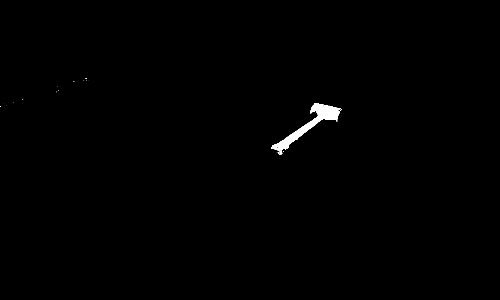

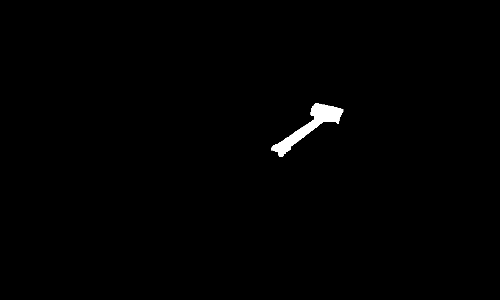

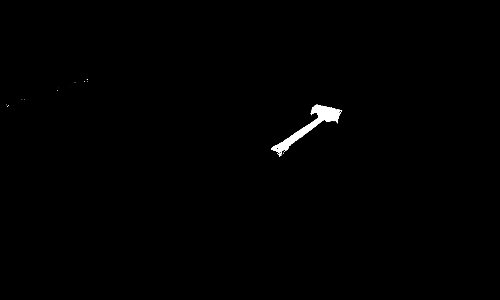

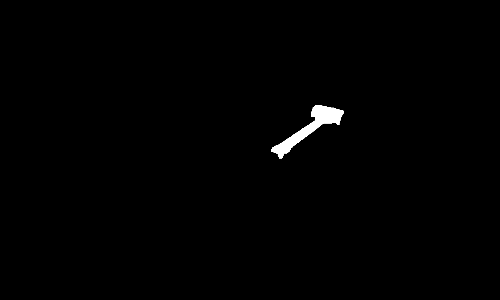

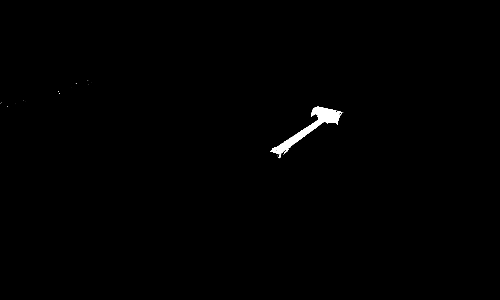

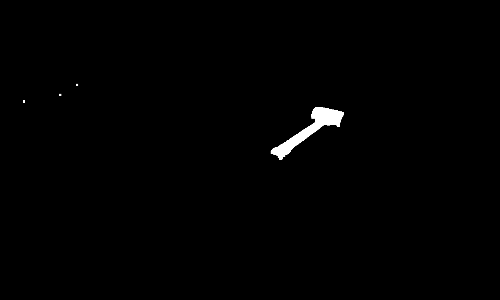

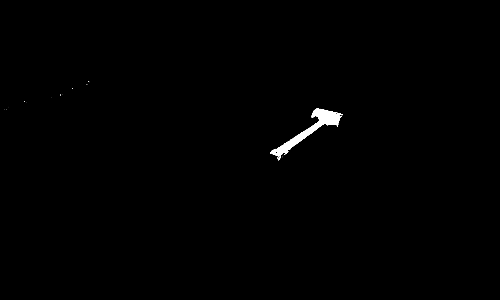

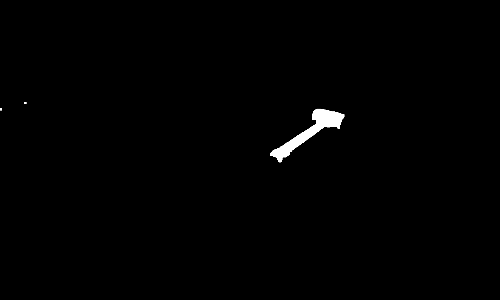

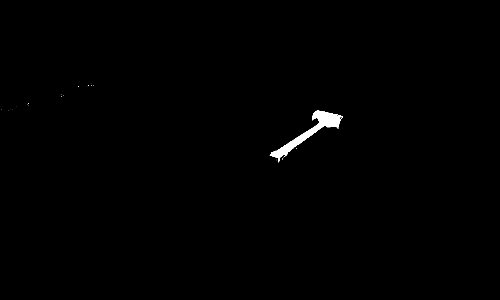

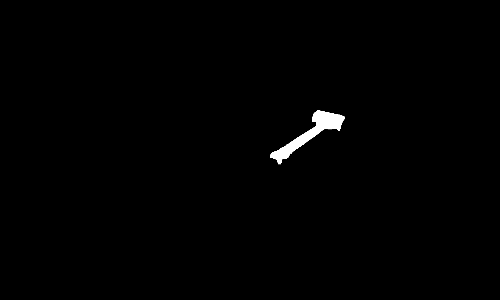

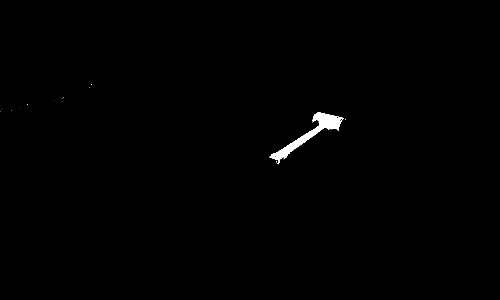

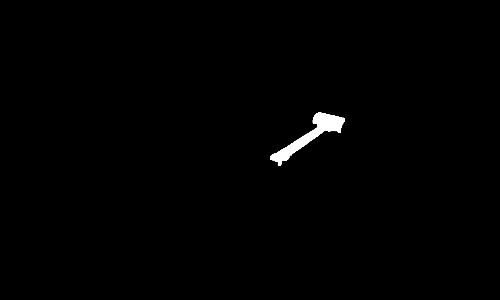

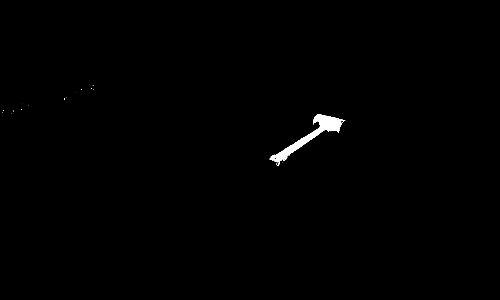

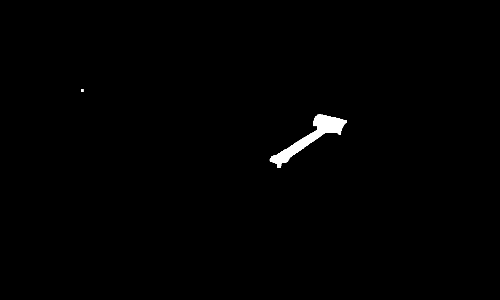

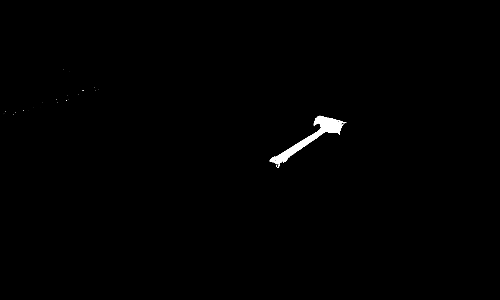

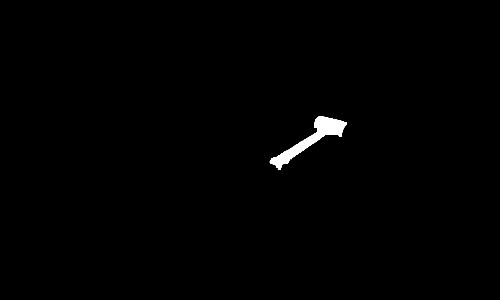

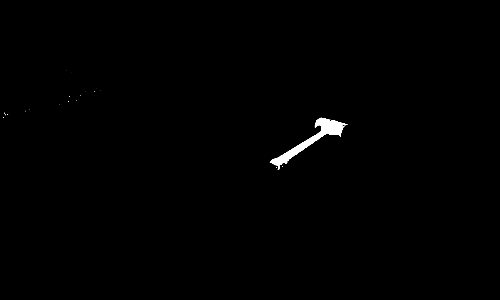

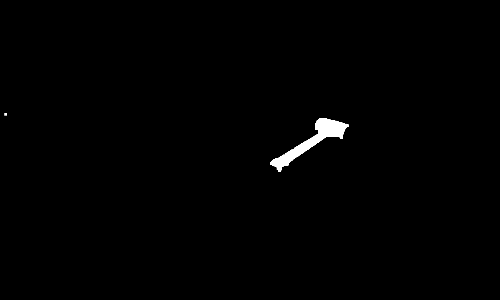

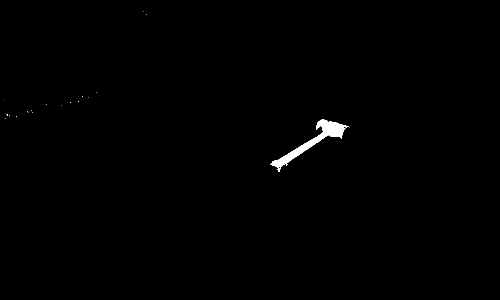

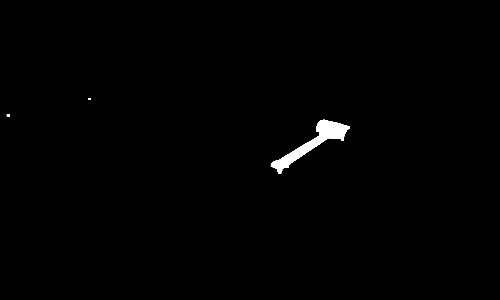

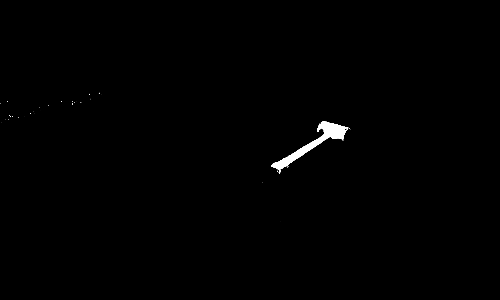

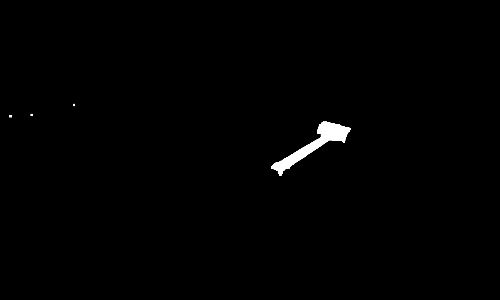

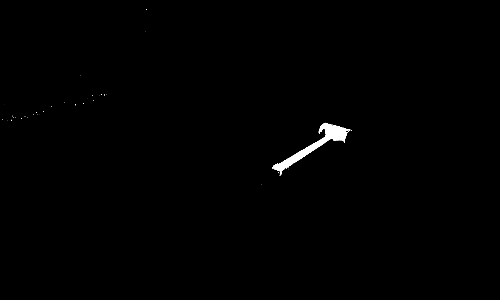

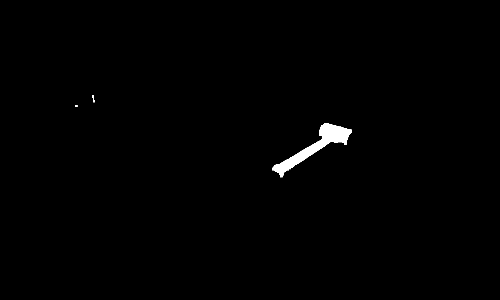

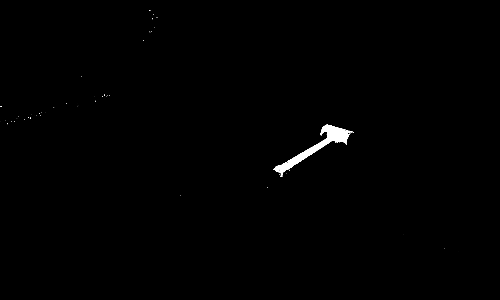

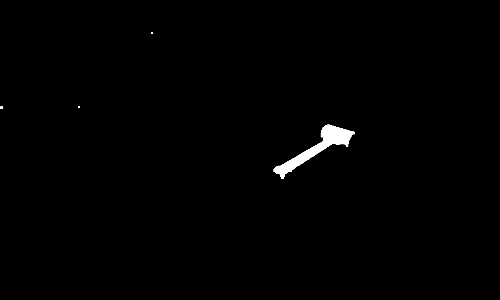

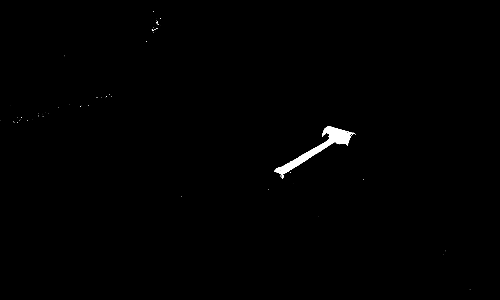

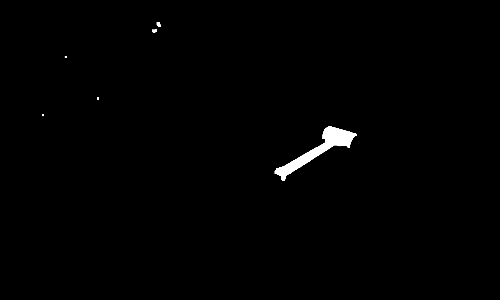

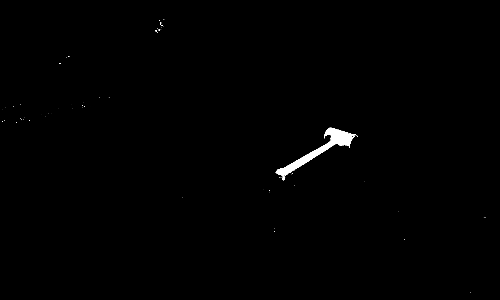

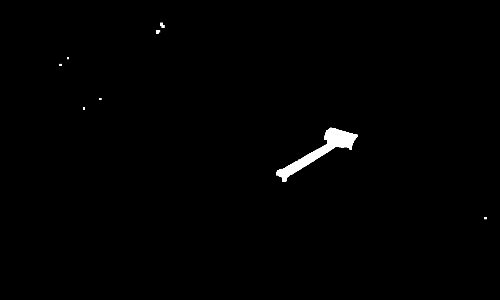

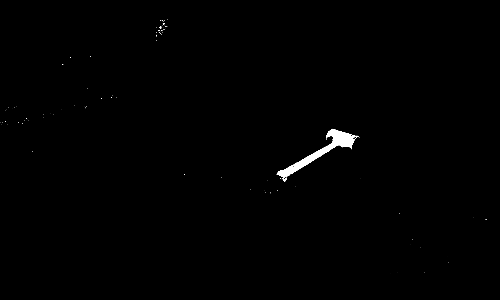

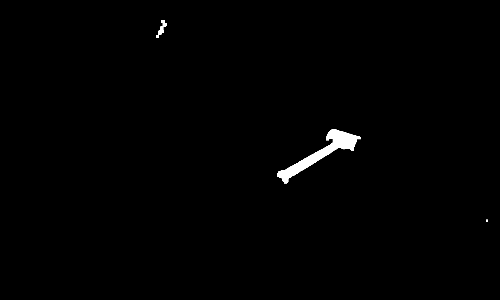

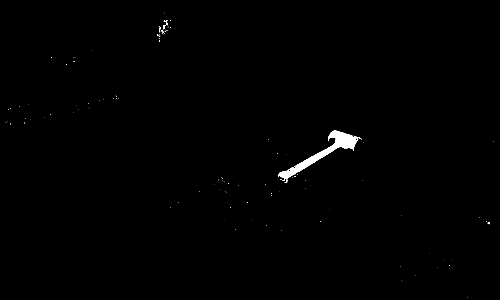

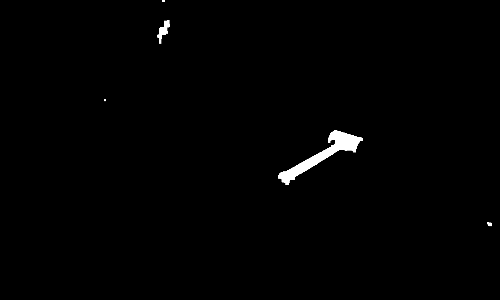

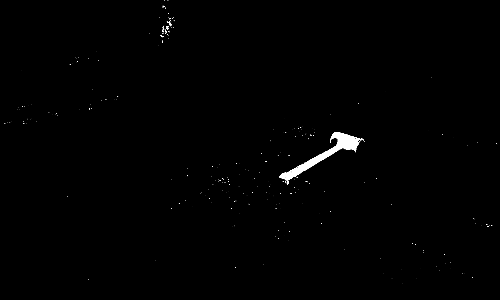

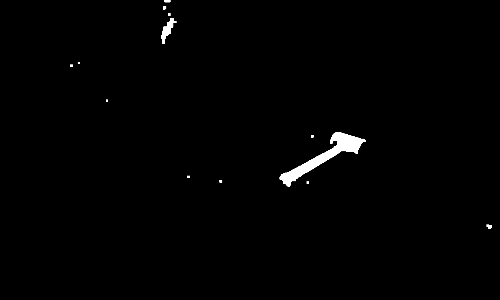

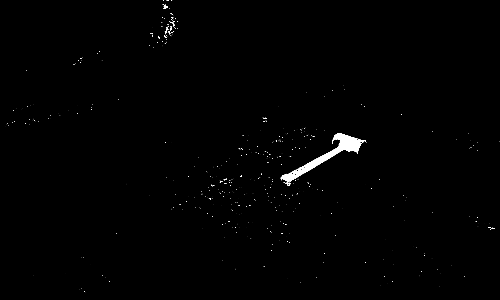

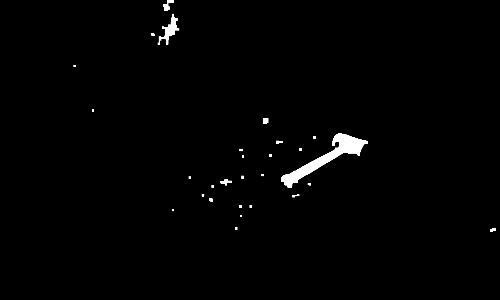

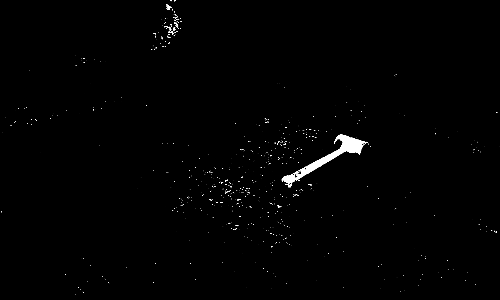

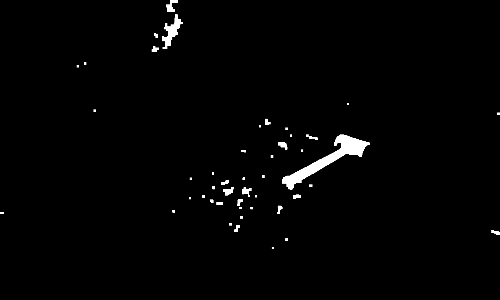

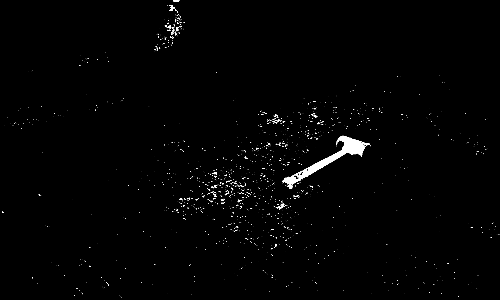

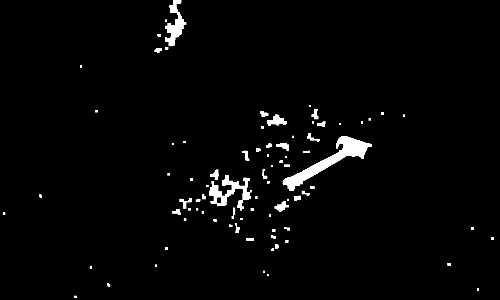

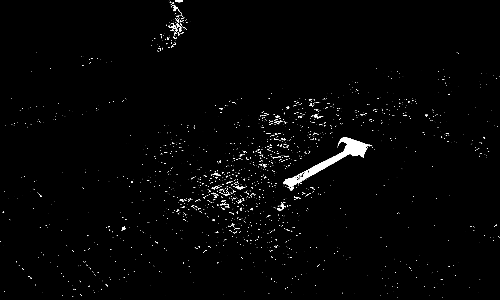

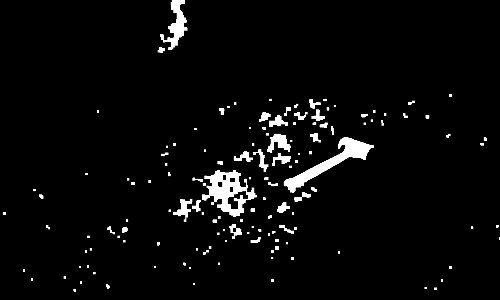

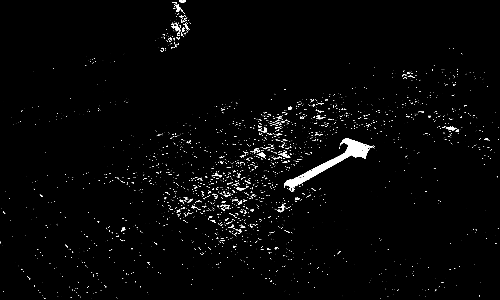

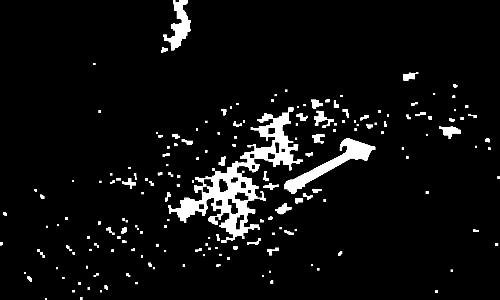

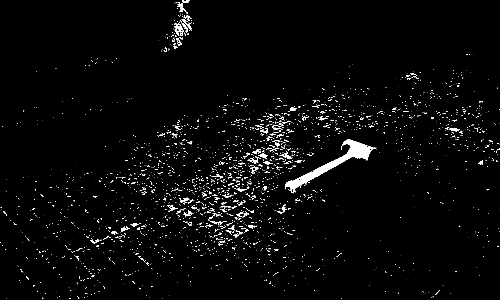

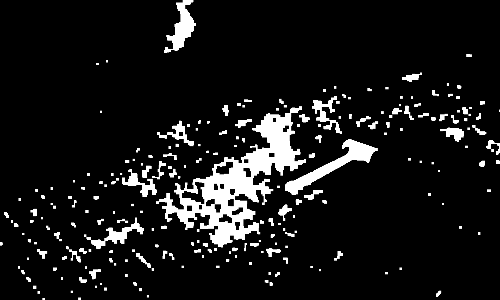

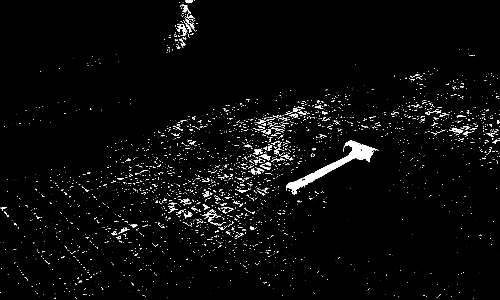

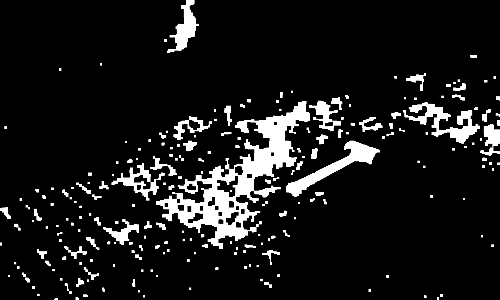

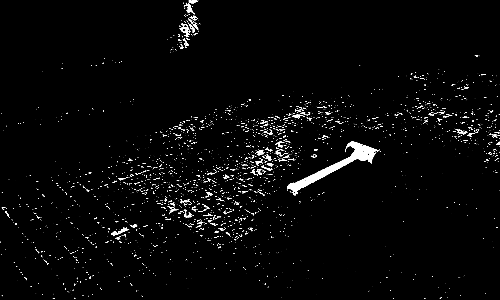

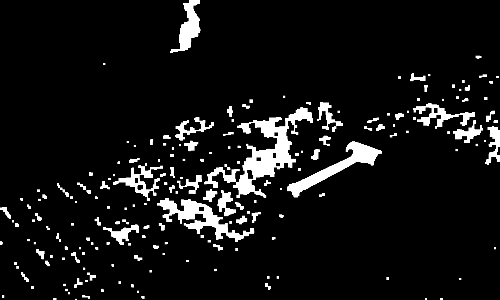

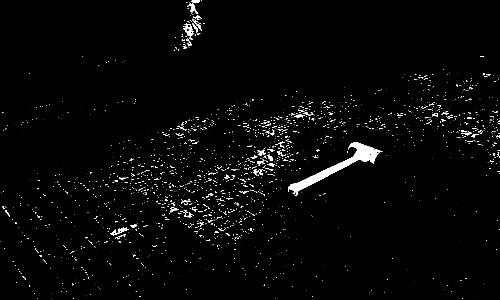

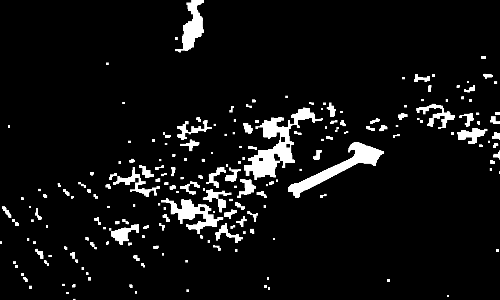

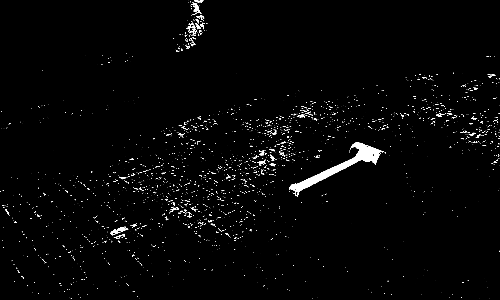

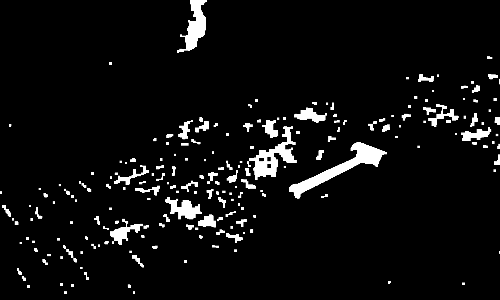

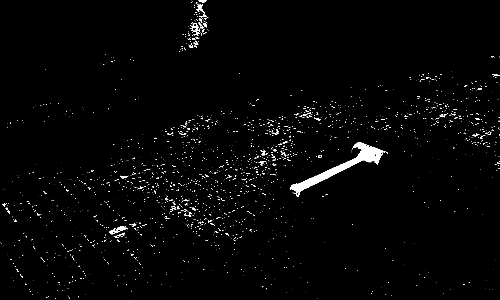

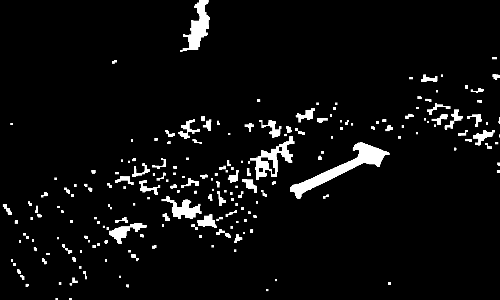

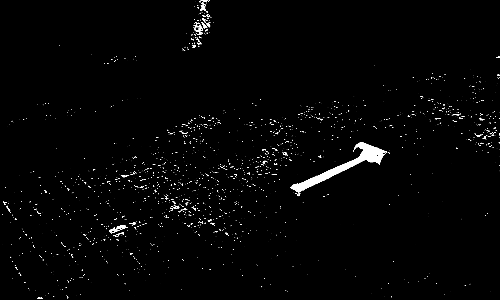

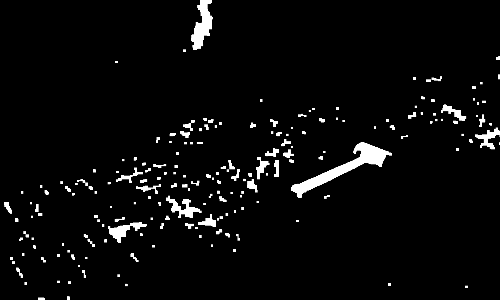

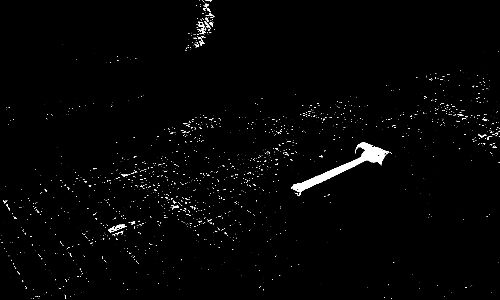

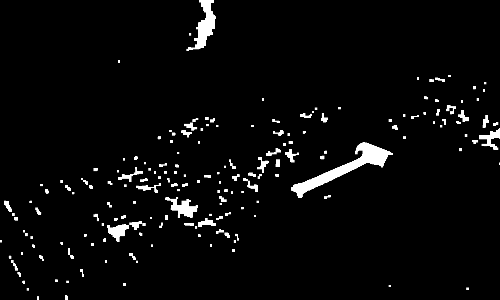

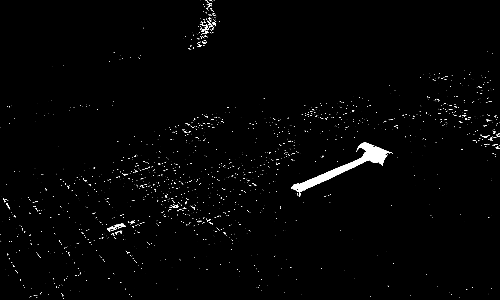

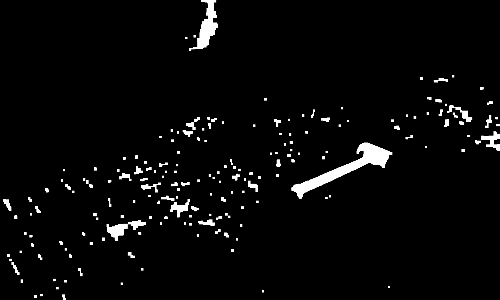

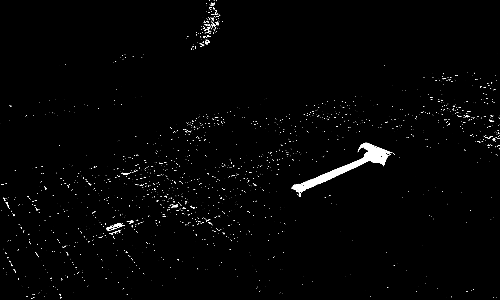

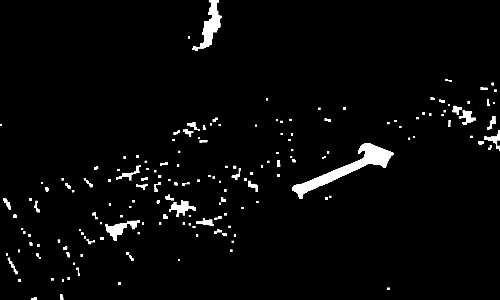

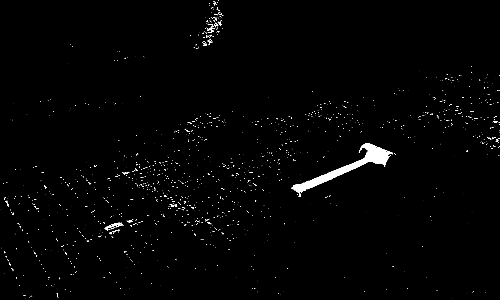

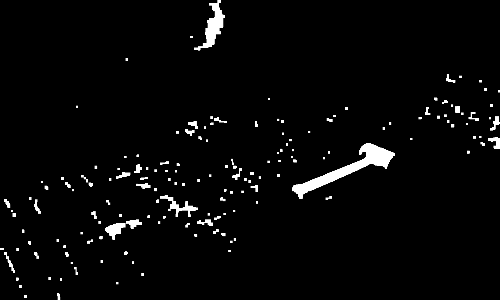

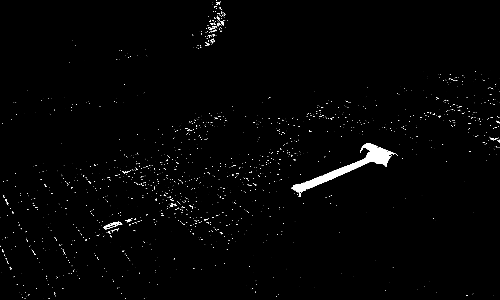

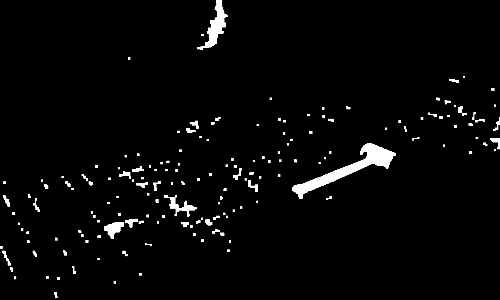

KeyboardInterrupt: 

In [11]:
cap = cv2.VideoCapture('Mallet_videos/IMG_9110.MOV')

if not cap.isOpened():
    print("Error opening video file. Check the path and file format.")
    exit()
else:
    print("Video opened successfully.")

desired_width = 320
desired_height = 500
display_size = (desired_width, desired_height)

fps = cap.get(cv2.CAP_PROP_FPS)

# CLAHE object for contrast enhancementfinal_mask
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break 
        
    prepros_lab = preprocess_image(frame)
    thresh = thresholding(prepros_lab)
    refine = refinement(thresh)
    
    cv2.imshow("original", frame)
    cv2.imshow("preprocess_image lab", prepros_lab)
    cv2.imshow("beforr refinement", thresh)
    cv2.imshow("final", refine)
    
    if cv2.waitKey(int(1000 / fps)) & 0xFF == ord('q'):
        break

cap.release()
